In [20]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from perceiver import tokenize_data, CustomDataset, PerceiverBlock, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [21]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [23]:
# def tokenize_data(df):
#     input_ids, attention_masks = [], []
    
#     df['Caption'] = df['Caption'].astype(str).fillna("")

#     for text in df['Caption']:
#         encoded = tokenizer(
#             text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
#         )
#         input_ids.append(encoded['input_ids'].squeeze(0))
#         attention_masks.append(encoded['attention_mask'].squeeze(0))
#     return torch.stack(input_ids), torch.stack(attention_masks)

# class CustomDataset(Dataset):
#     def __init__(self, input_ids, attention_masks, labels):
#         self.input_ids = input_ids
#         self.attention_masks = attention_masks
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.input_ids[idx],
#             'attention_mask': self.attention_masks[idx],
#             'labels': self.labels[idx]
#         }

# class PerceiverBlock(nn.Module):
  
#     def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
#         super().__init__()
        
#         self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
#         self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

    
#         self.self_attn_layers = nn.ModuleList([
#             nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
#             for _ in range(self_attn_layers)
#         ])

#     def forward(self, latents, x):
#         # latents, x: (T, B, dim) 형태로 가정
#         # Perceiver 원리상 latents는 query, x는 key/value

       
#         updated_latents, _ = self.cross_attn(latents, x, x)
#         latents = latents + updated_latents       
#         latents = self.cross_ln(latents)        
  
#         for layer in self.self_attn_layers:
  
#            latents = layer(latents)  
#         return latents

# class Perceiver(nn.Module):
#     def __init__(self, input_dim, latent_dim, latent_size, num_classes,
#                  num_blocks, self_attn_layers_per_block=1):
#         super().__init__()
#         self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
#         self.input_projection = nn.Linear(input_dim, latent_dim)

#         # 여러 개의 PerceiverBlock을 쌓음
#         self.blocks = nn.ModuleList([
#             PerceiverBlock(
#                 latent_dim=latent_dim,
#                 n_heads=8,
#                 self_attn_layers=self_attn_layers_per_block
#             )
#             for _ in range(num_blocks)
#         ])

#         self.output_layer = nn.Linear(latent_dim, num_classes)

#     def forward(self, x):
#         """
#         x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
#         """
#         B, T, F = x.size()
#         x = self.input_projection(x)                 # (B, T, latent_dim)

#         # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
#         latents = self.latents.unsqueeze(0).expand(B, -1, -1)

#         # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
#         x = x.permute(1, 0, 2)        # (T, B, latent_dim)
#         latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

#         # PerceiverBlock을 여러 번 반복
#         for block in self.blocks:
#             latents = block(latents, x)

#         # 최종 latents: (latent_size, B, latent_dim)
#         latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
#         return self.output_layer(latents)

# class CombinedModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, perceiver_model):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)
#         self.perceiver = perceiver_model

#     def forward(self, input_ids):
#         embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
#         return self.perceiver(embeddings)  


In [24]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [25]:
model_path = '/home/Minju/Perceiver/model'
loader_path = '/home/Minju/Perceiver/loader'


group 1 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.8993, train acc: 0.5345
                               test loss: 0.6772, test acc: 0.7087
    epoch 5/15: train loss: 0.1739, train acc: 0.9466
                               test loss: 0.3921, test acc: 0.8814
    epoch 10/15: train loss: 0.0363, train acc: 0.9915
                               test loss: 0.6325, test acc: 0.8662
    epoch 15/15: train loss: 0.0152, train acc: 0.9974
                               test loss: 0.7171, test acc: 0.8752

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.8716, train acc: 0.5710
                               test loss: 0.5766, test acc: 0.7828
    epoch 5/15: train loss: 0.1932, train acc: 0.9372
                               test loss: 0.3746, test acc: 0.8765
    epoch 10/15: train loss: 0.0483, train acc: 0.9875
                               test loss: 0.6033, test acc: 0.8598
    epoch 15/15: train loss: 0.0182, train acc: 0.9967
                               test lo

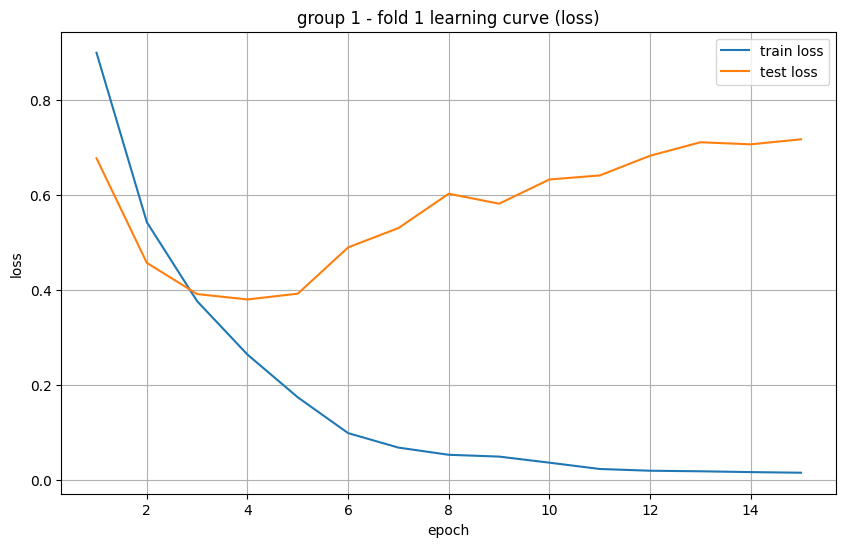

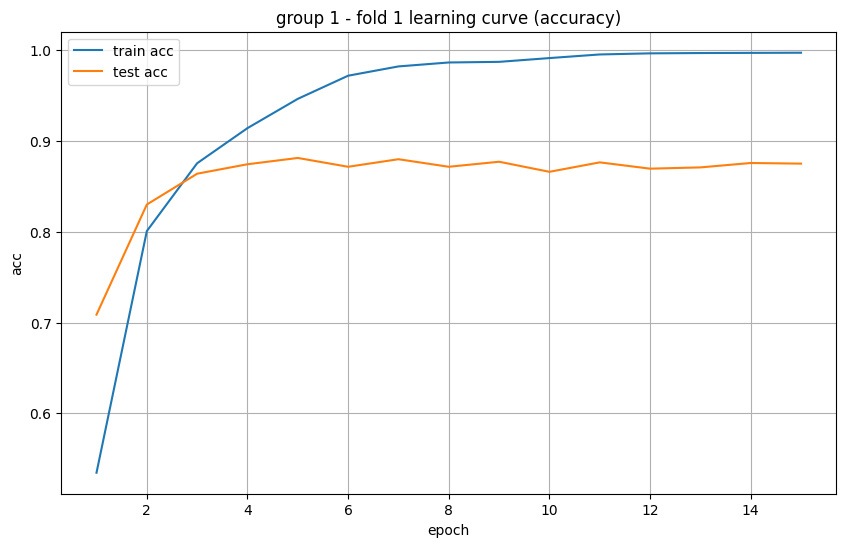

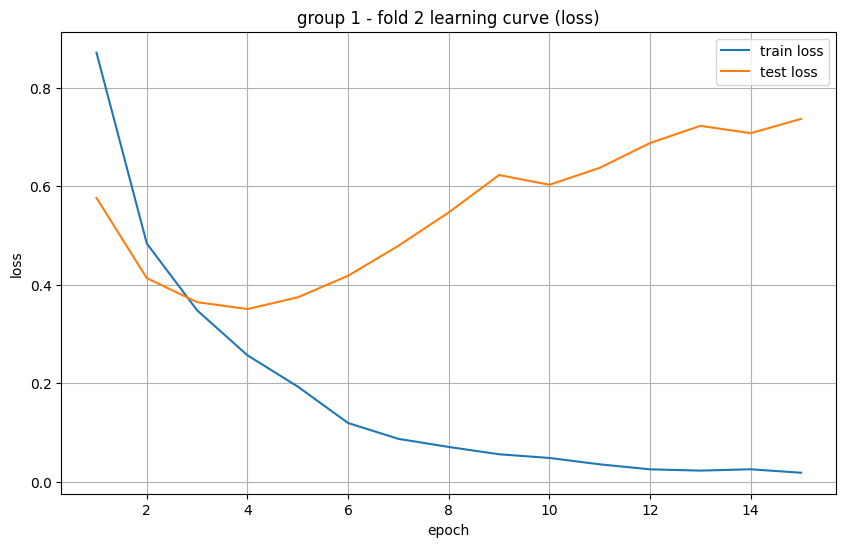

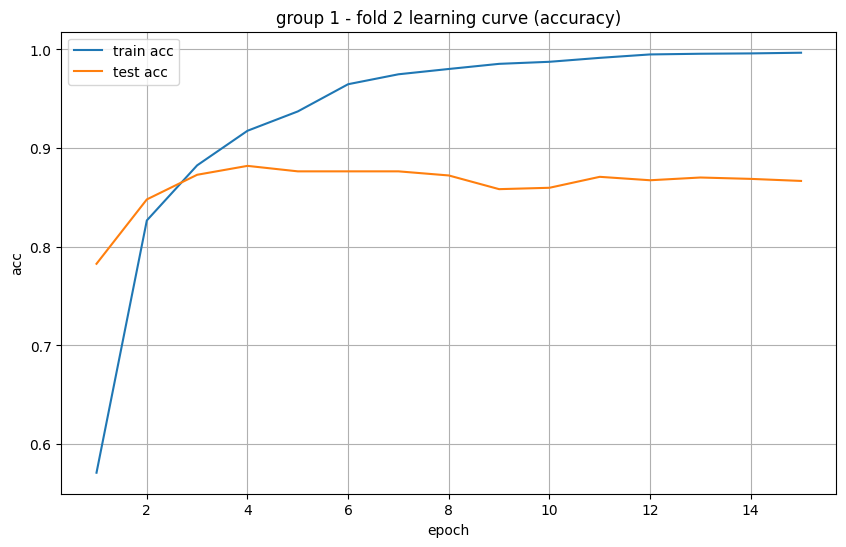

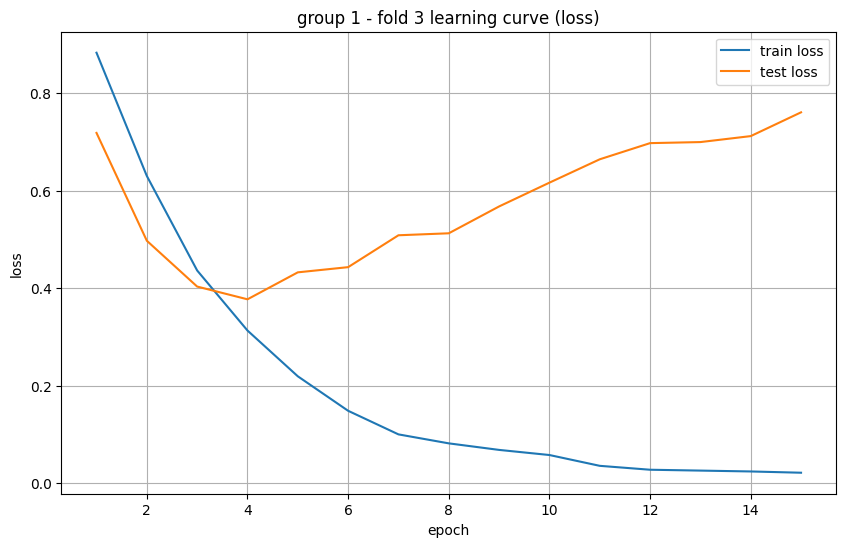

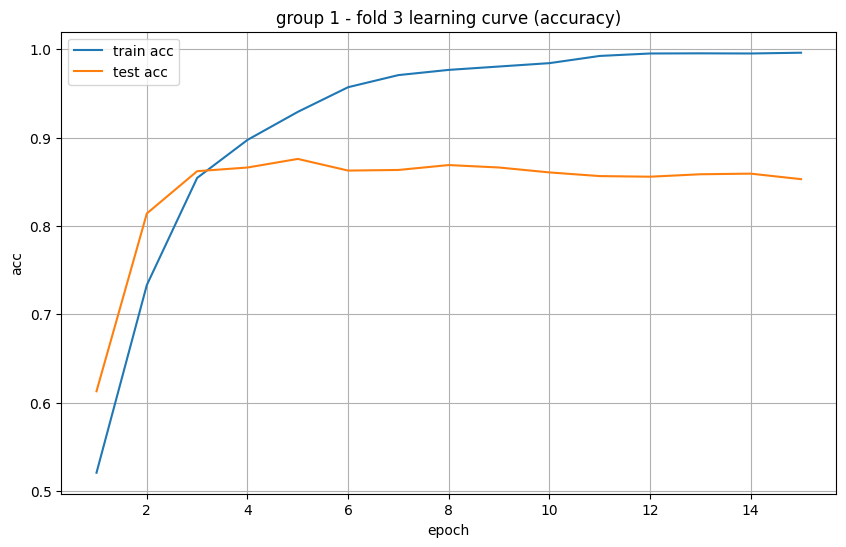

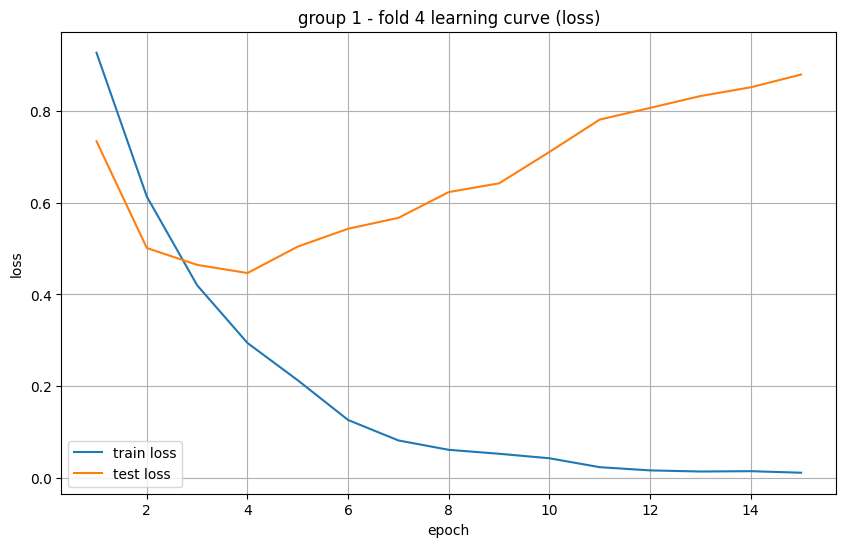

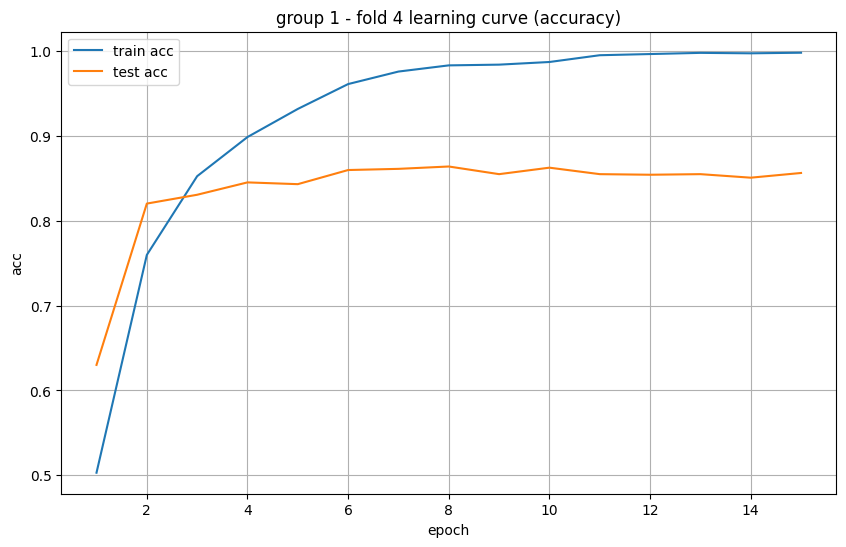

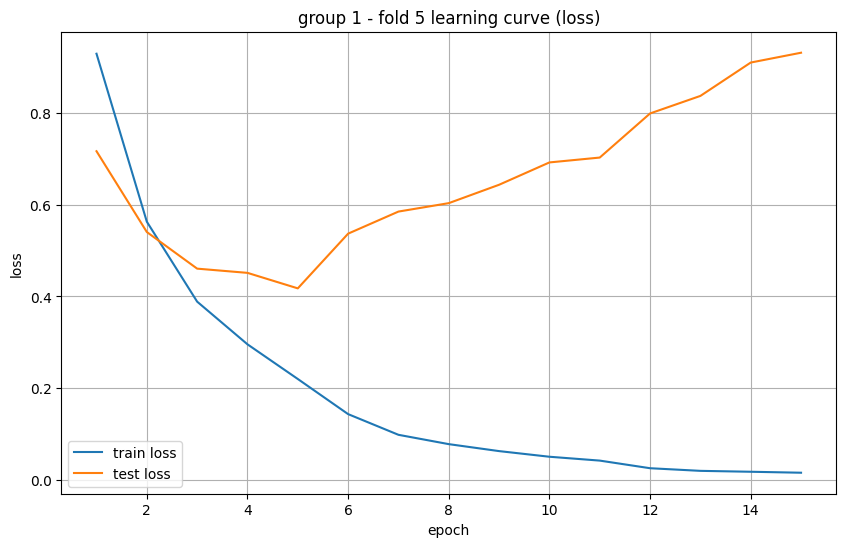

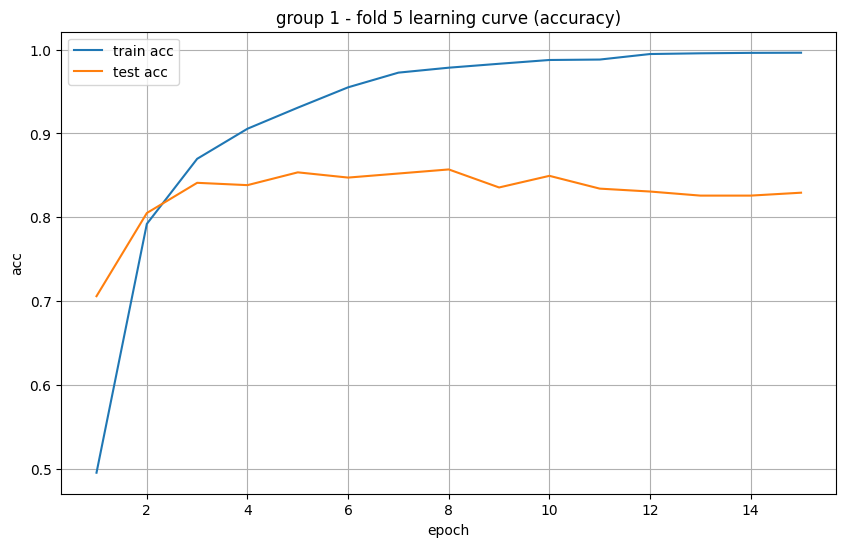

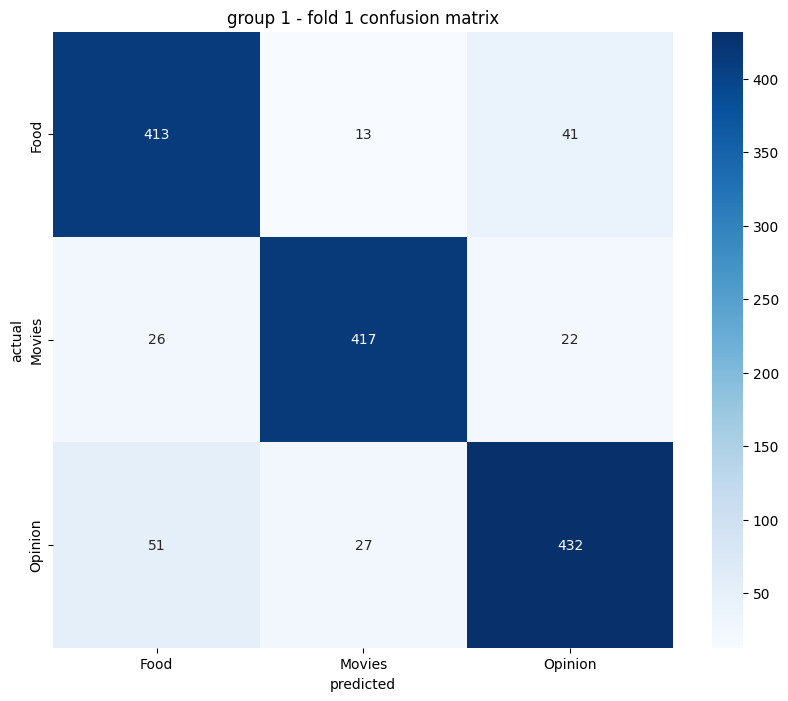

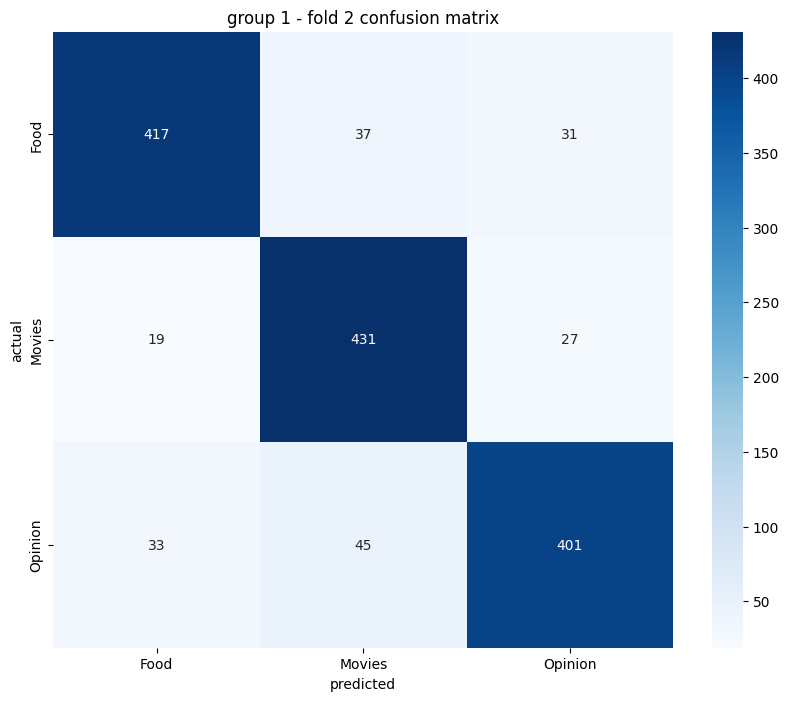

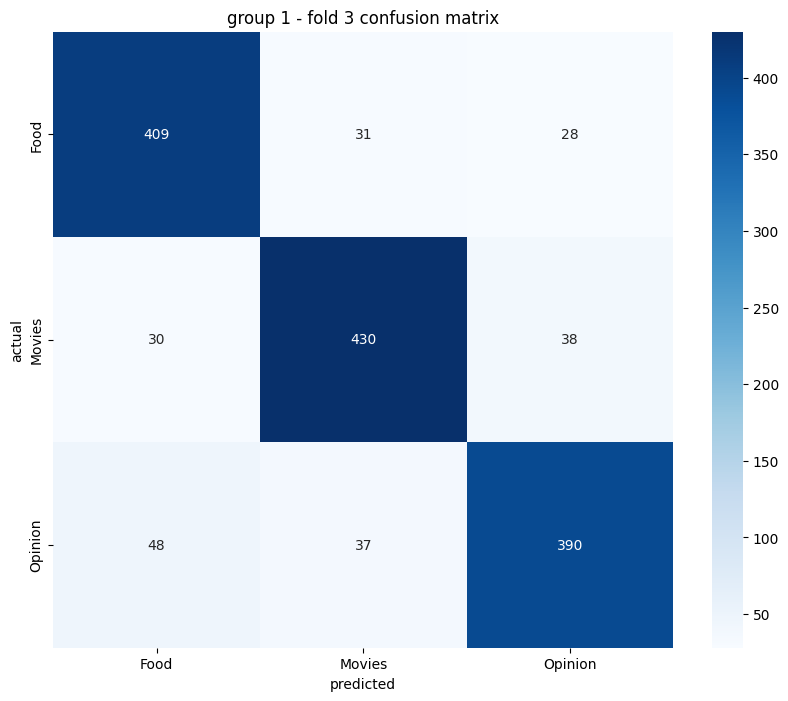

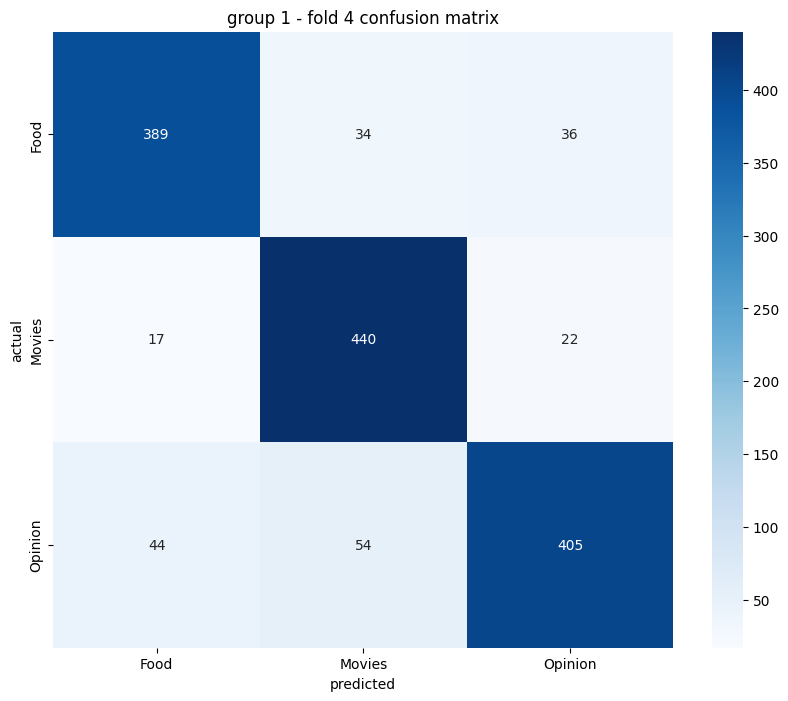

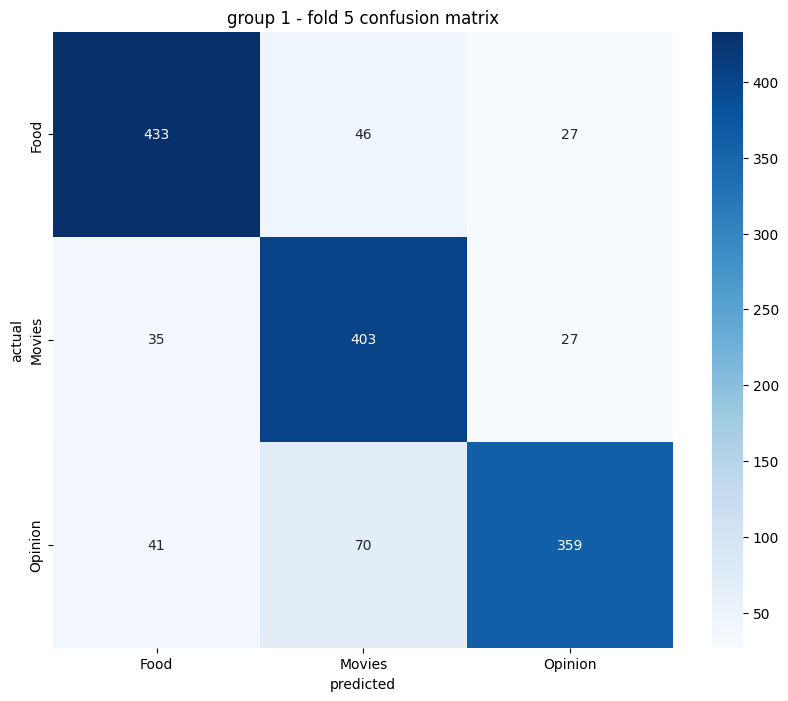


group 2 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0300, train acc: 0.4698
                               test loss: 0.8123, test acc: 0.6516
    epoch 5/15: train loss: 0.2796, train acc: 0.9068
                               test loss: 0.5064, test acc: 0.8001
    epoch 10/15: train loss: 0.0525, train acc: 0.9866
                               test loss: 0.8719, test acc: 0.8057
    epoch 15/15: train loss: 0.0205, train acc: 0.9960
                               test loss: 1.0396, test acc: 0.7988

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0042, train acc: 0.4955
                               test loss: 0.8513, test acc: 0.6357
    epoch 5/15: train loss: 0.2404, train acc: 0.9148
                               test loss: 0.6247, test acc: 0.7793
    epoch 10/15: train loss: 0.0372, train acc: 0.9894
                               test loss: 1.0333, test acc: 0.7745
    epoch 15/15: train loss: 0.0093, train acc: 0.9984
                               test lo

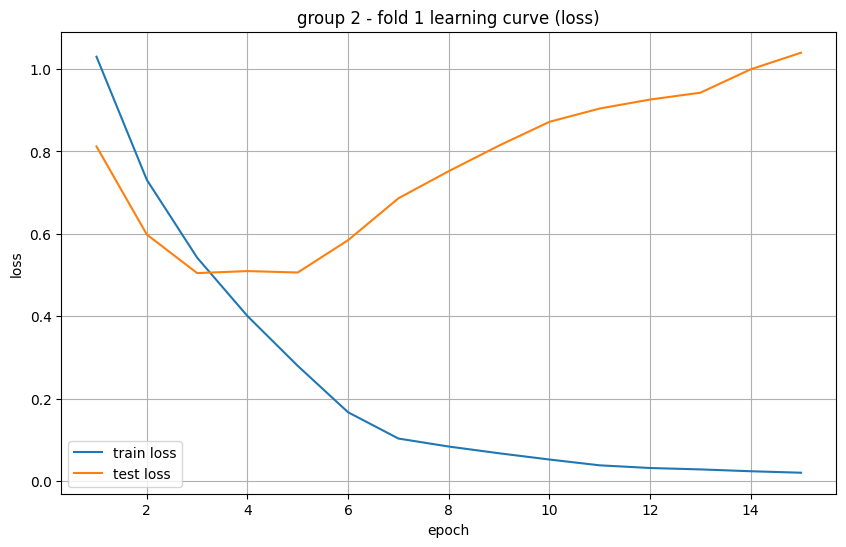

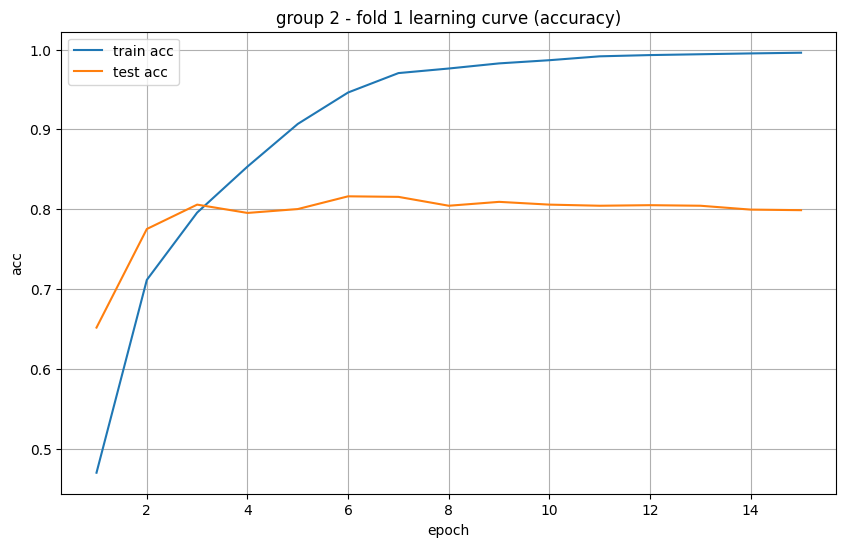

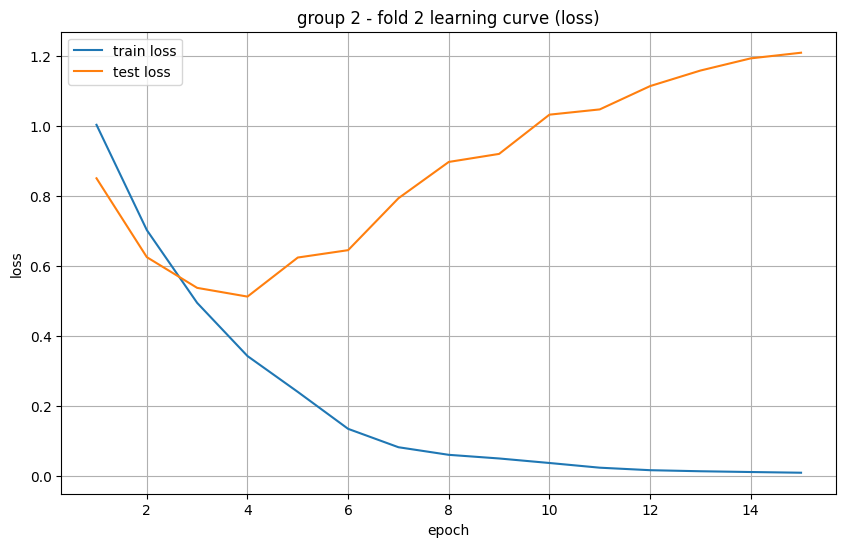

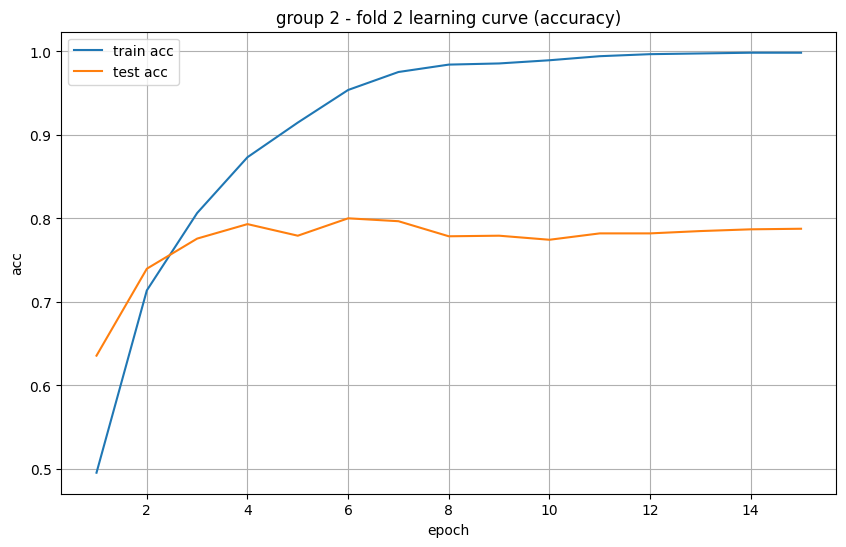

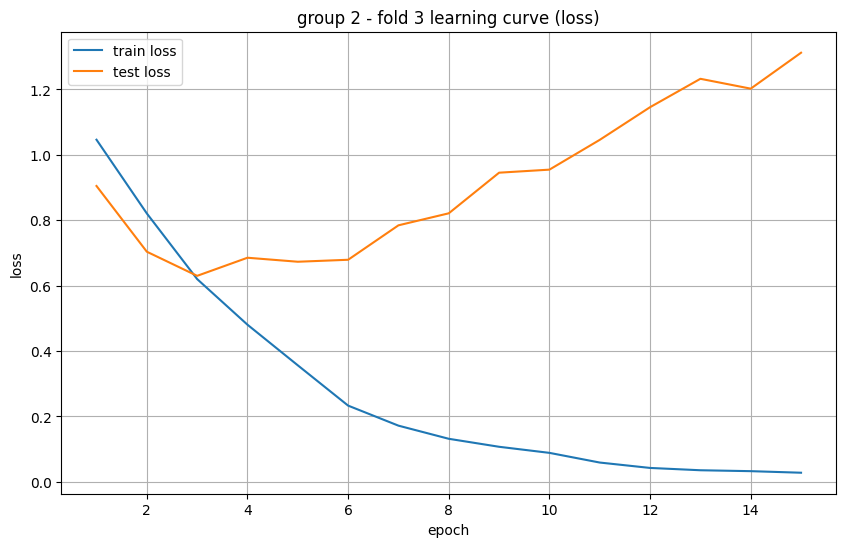

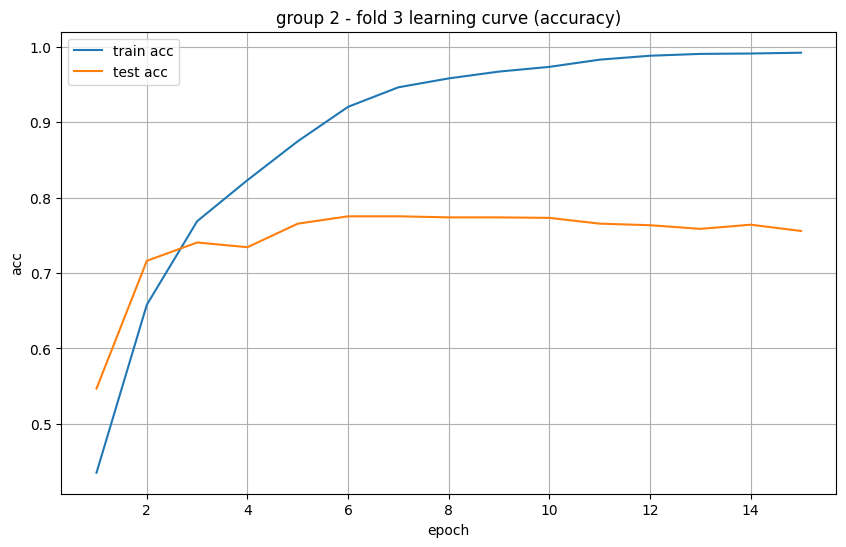

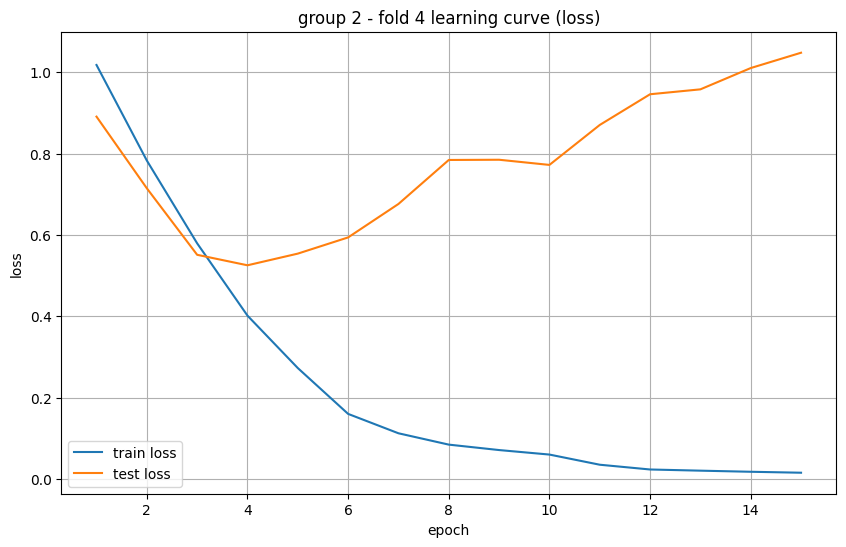

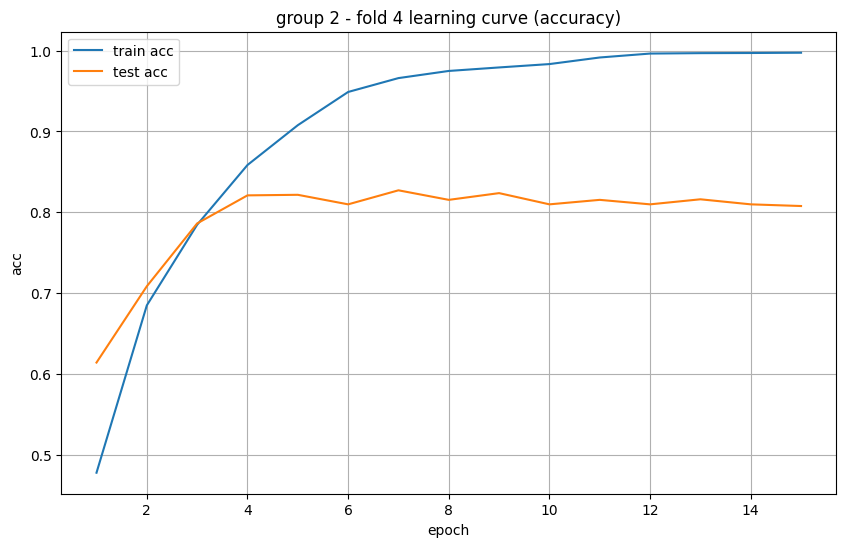

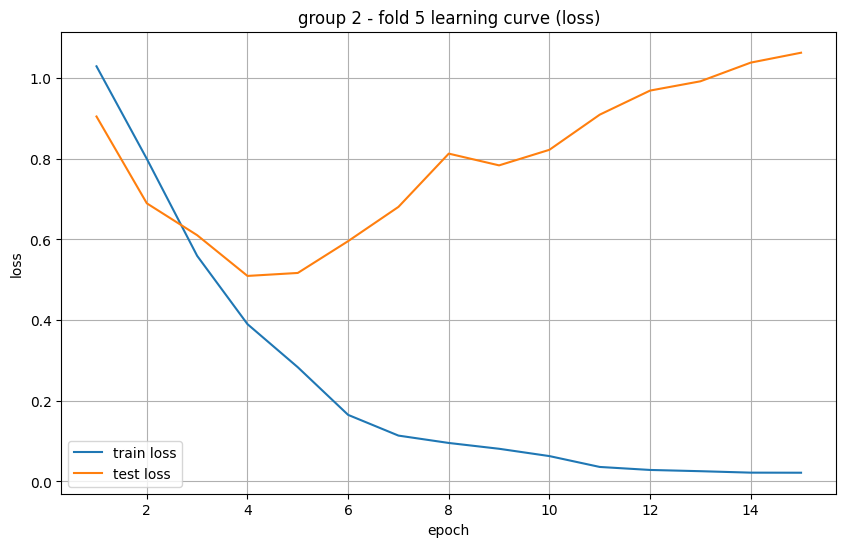

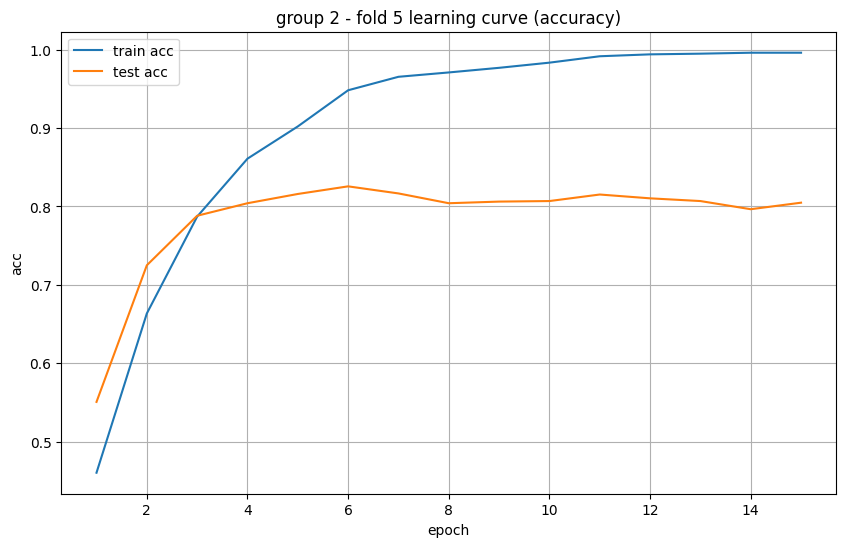

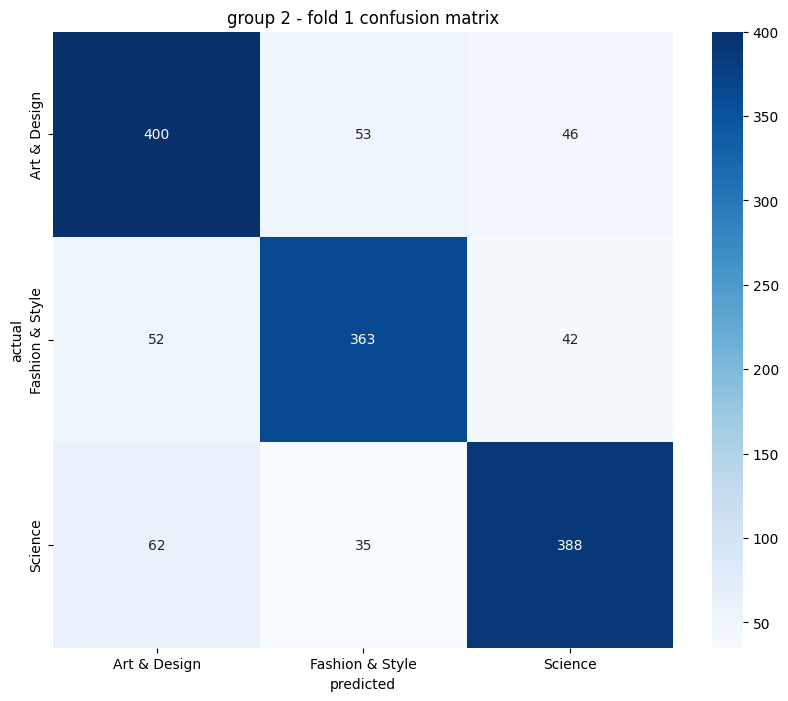

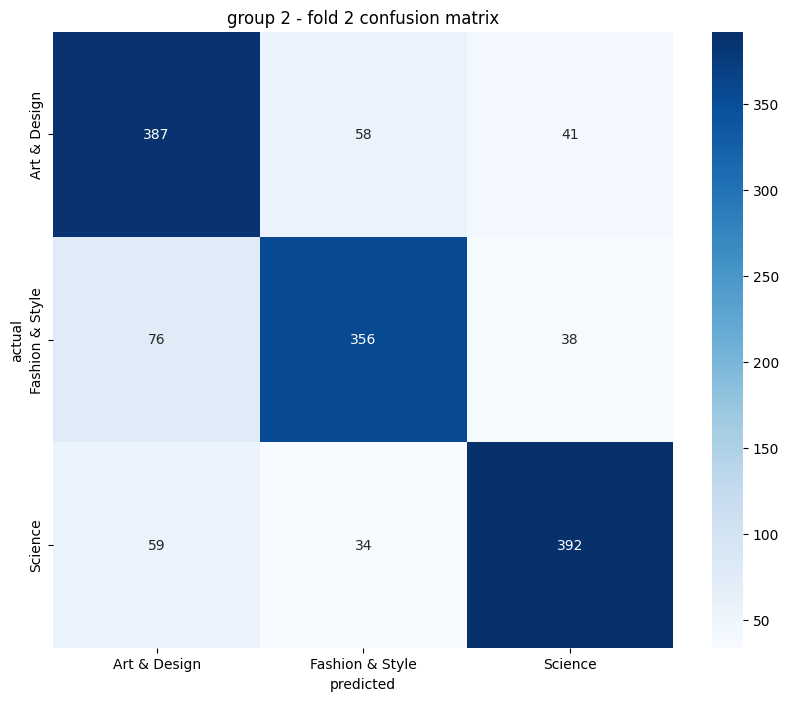

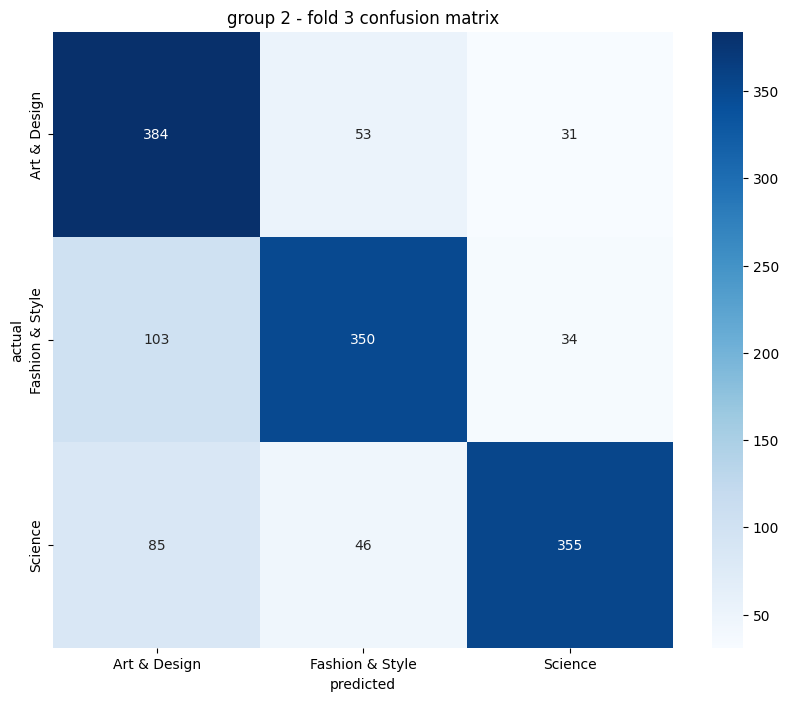

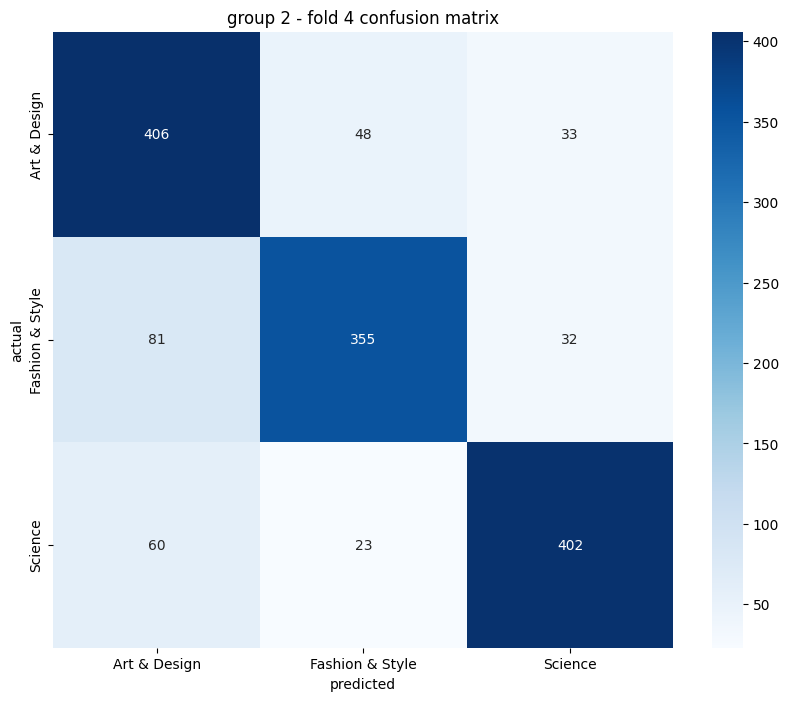

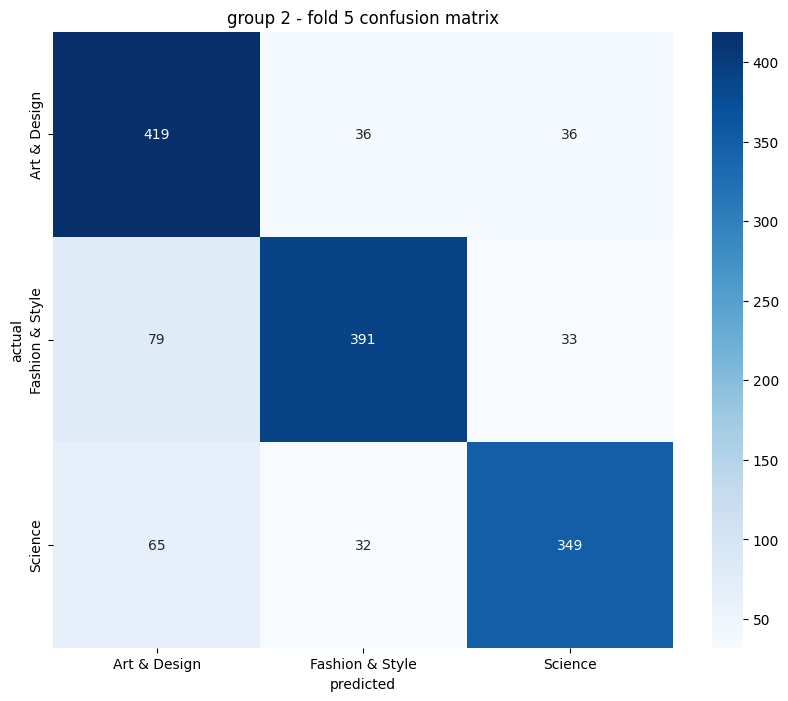


group 3 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.9923, train acc: 0.4912
                               test loss: 0.7135, test acc: 0.7269
    epoch 5/15: train loss: 0.2726, train acc: 0.9037
                               test loss: 0.4935, test acc: 0.8151
    epoch 10/15: train loss: 0.0640, train acc: 0.9808
                               test loss: 0.8151, test acc: 0.8050
    epoch 15/15: train loss: 0.0185, train acc: 0.9968
                               test loss: 1.1190, test acc: 0.8043

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.9886, train acc: 0.4923
                               test loss: 0.7923, test acc: 0.6609
    epoch 5/15: train loss: 0.3161, train acc: 0.8876
                               test loss: 0.5640, test acc: 0.8151
    epoch 10/15: train loss: 0.0712, train acc: 0.9801
                               test loss: 0.8729, test acc: 0.7935
    epoch 15/15: train loss: 0.0262, train acc: 0.9955
                               test lo

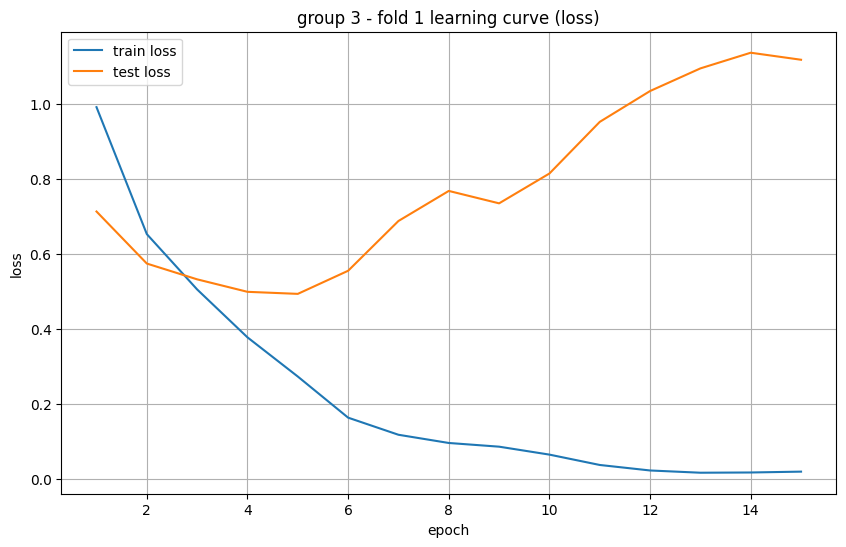

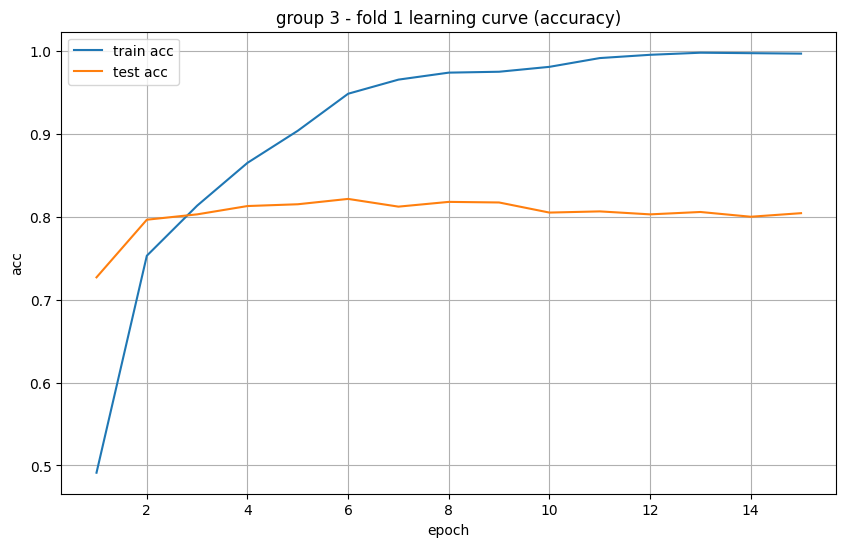

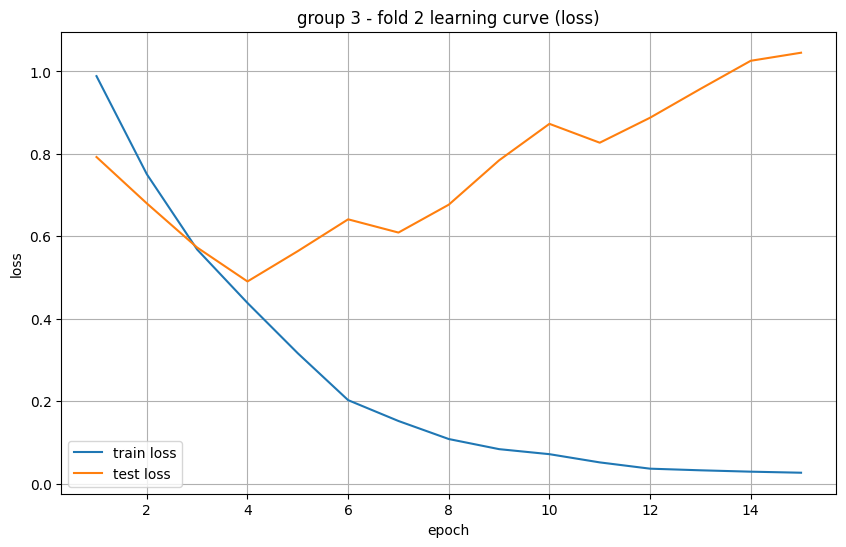

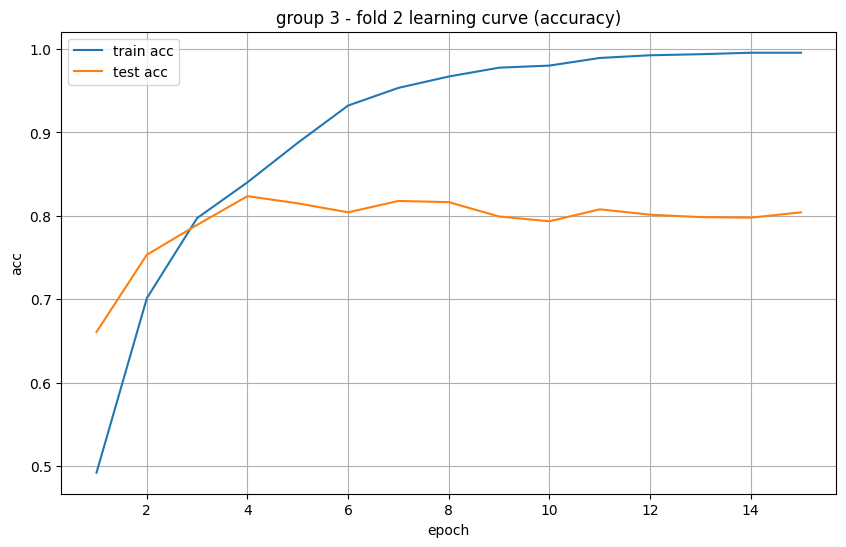

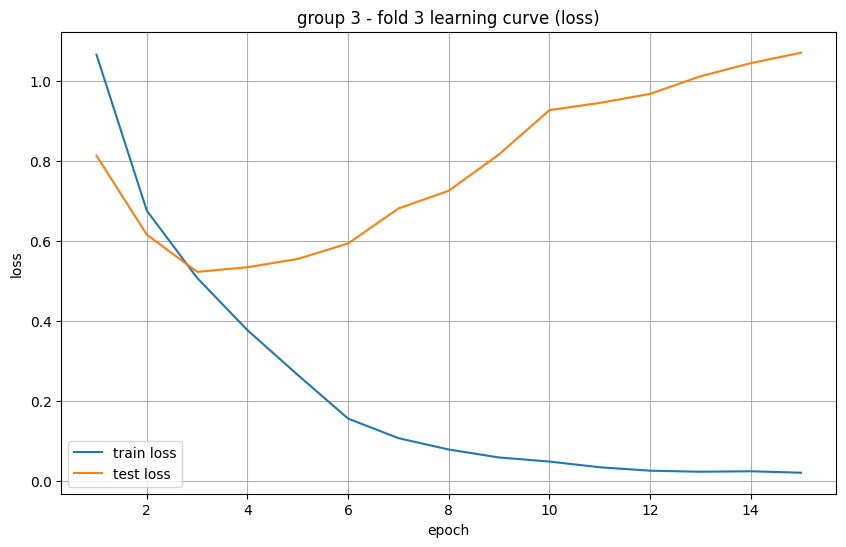

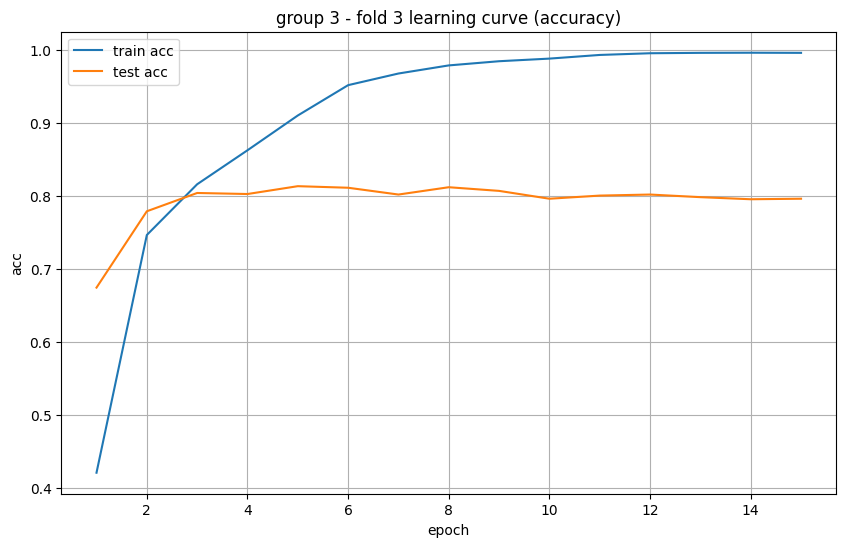

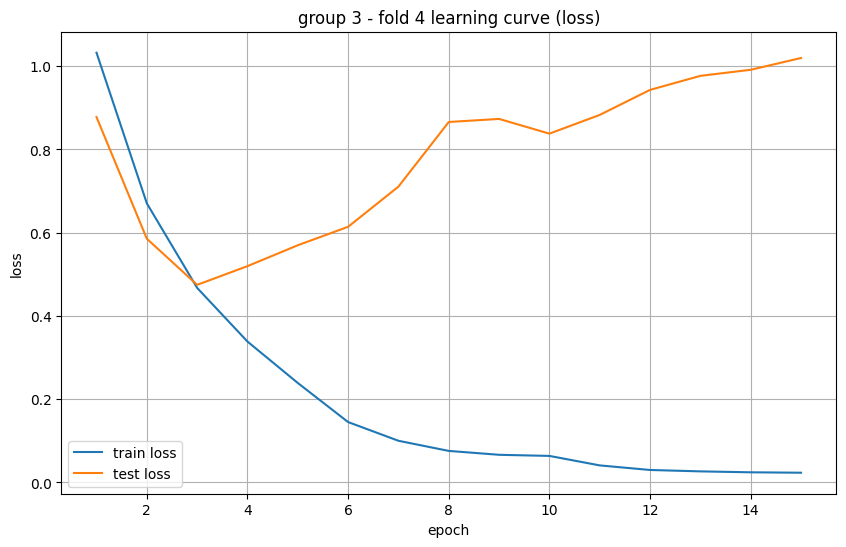

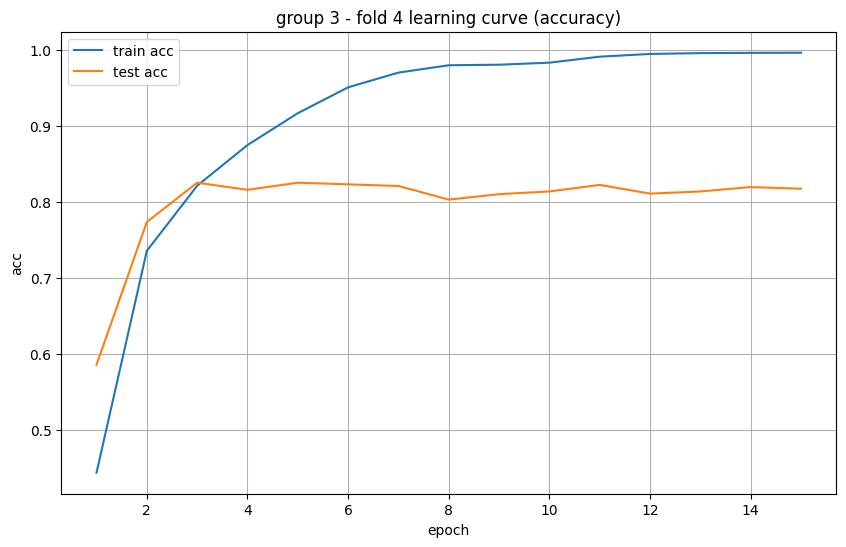

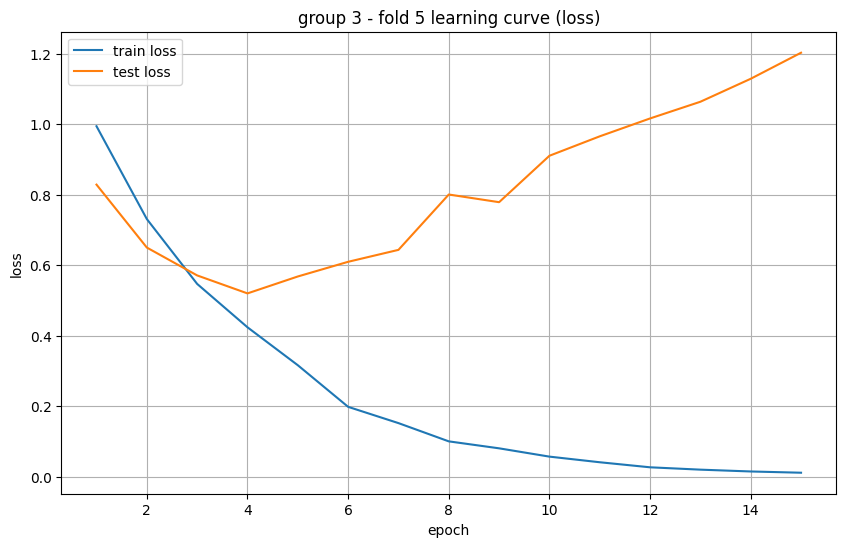

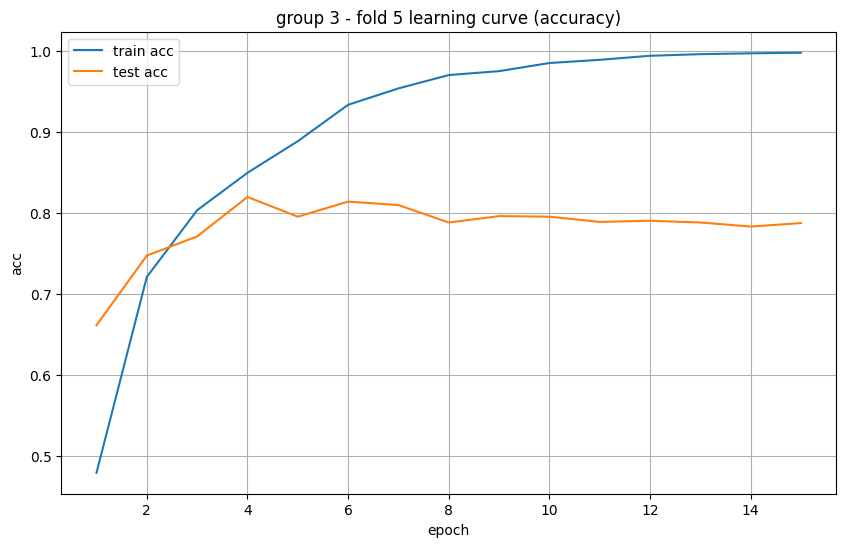

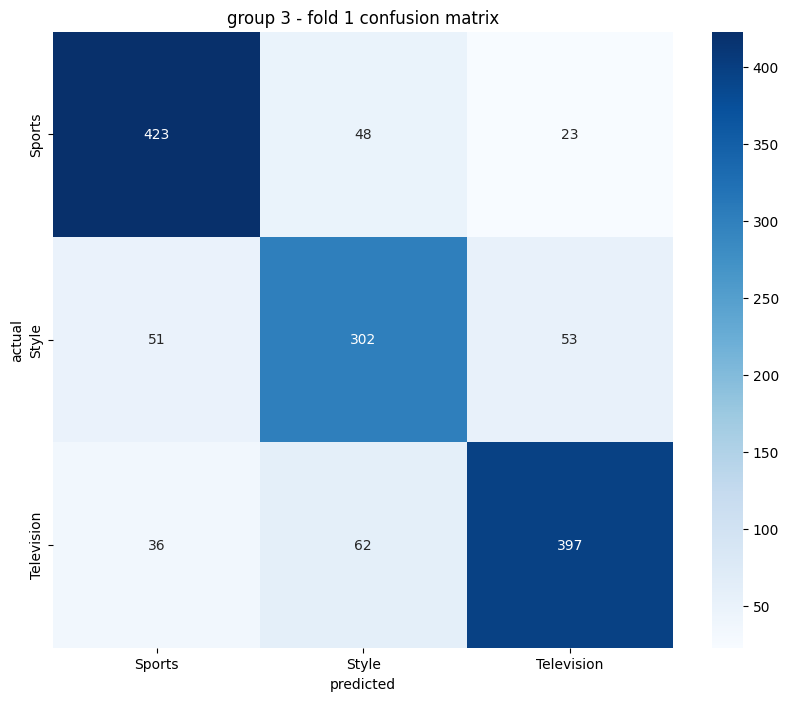

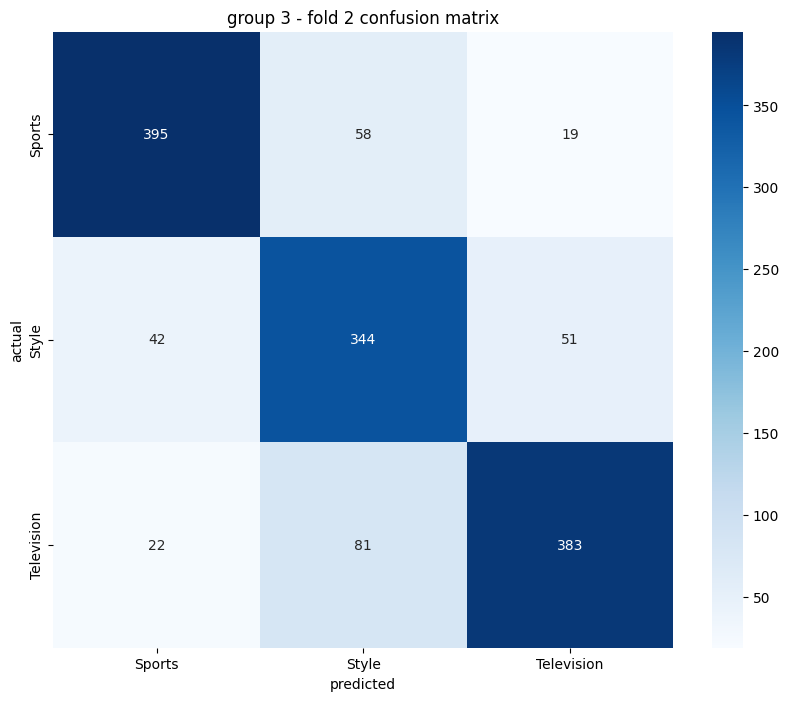

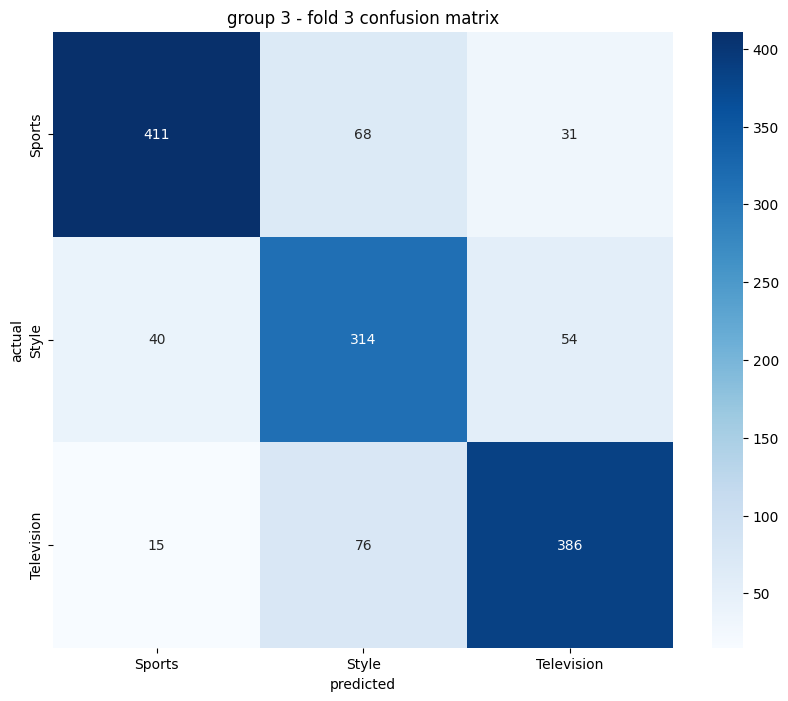

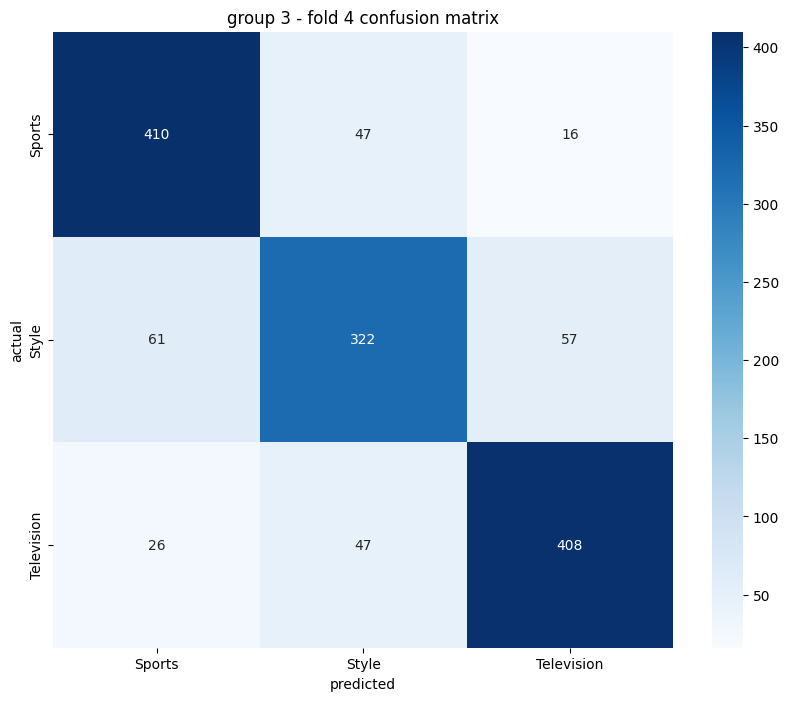

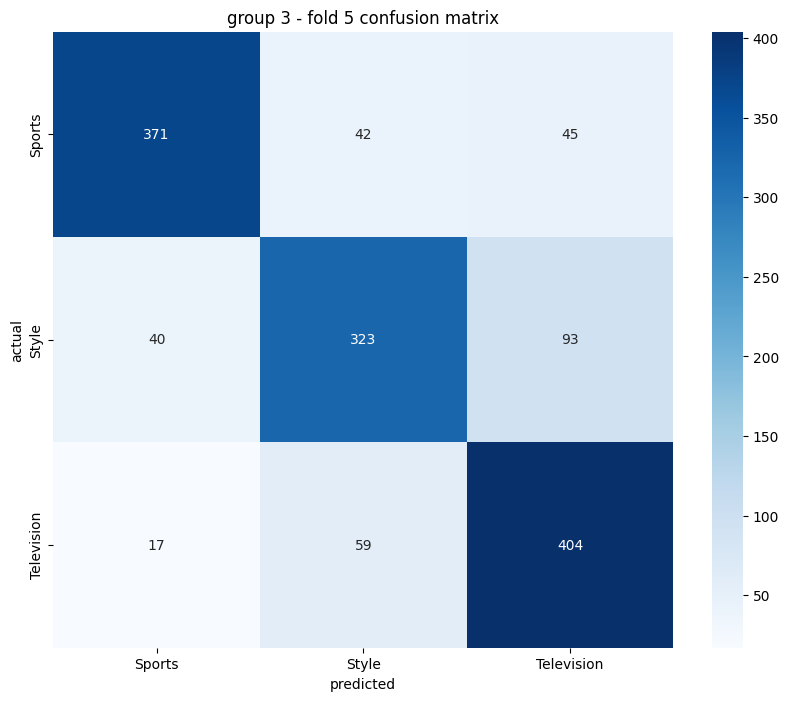


group 4 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0645, train acc: 0.4329
                               test loss: 0.8257, test acc: 0.5994
    epoch 5/15: train loss: 0.1406, train acc: 0.9511
                               test loss: 0.4533, test acc: 0.8581
    epoch 10/15: train loss: 0.0221, train acc: 0.9948
                               test loss: 0.7508, test acc: 0.8561
    epoch 15/15: train loss: 0.0068, train acc: 0.9988
                               test loss: 0.8245, test acc: 0.8595

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0515, train acc: 0.4039
                               test loss: 0.8232, test acc: 0.6085
    epoch 5/15: train loss: 0.1535, train acc: 0.9489
                               test loss: 0.4089, test acc: 0.8700
    epoch 10/15: train loss: 0.0184, train acc: 0.9955
                               test loss: 0.6985, test acc: 0.8700
    epoch 15/15: train loss: 0.0037, train acc: 0.9995
                               test lo

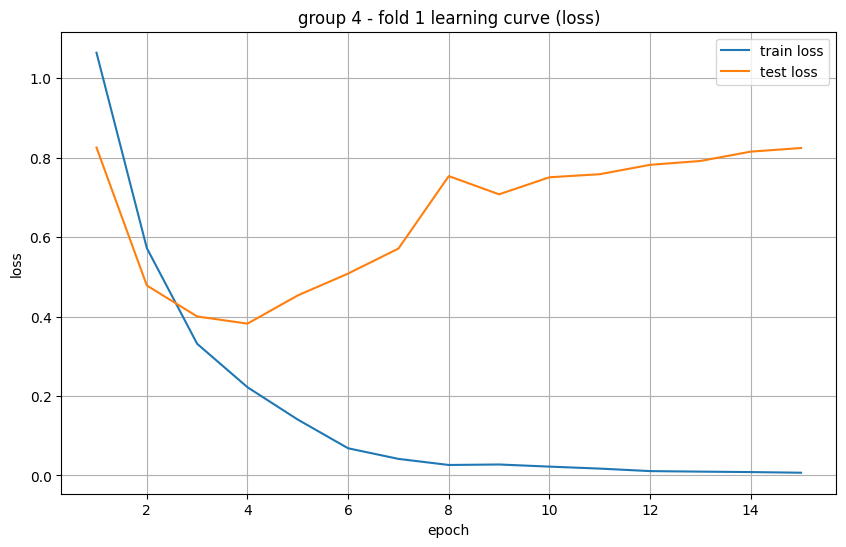

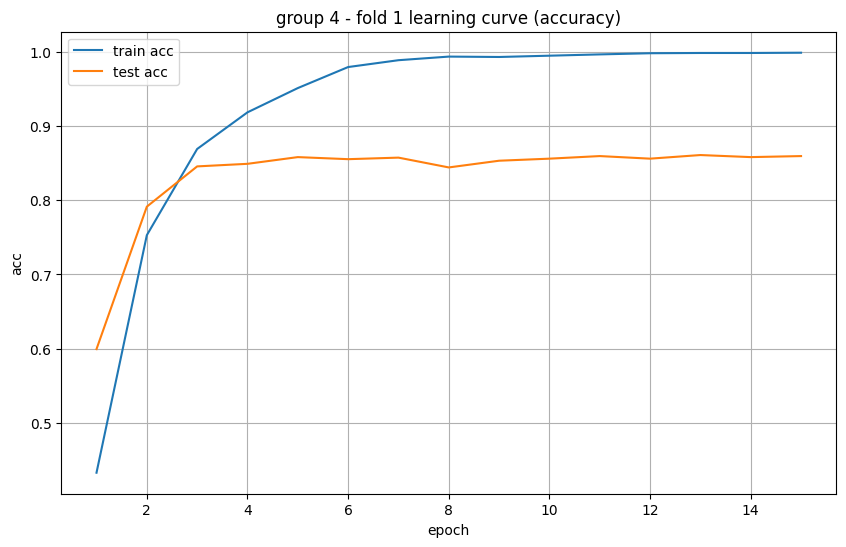

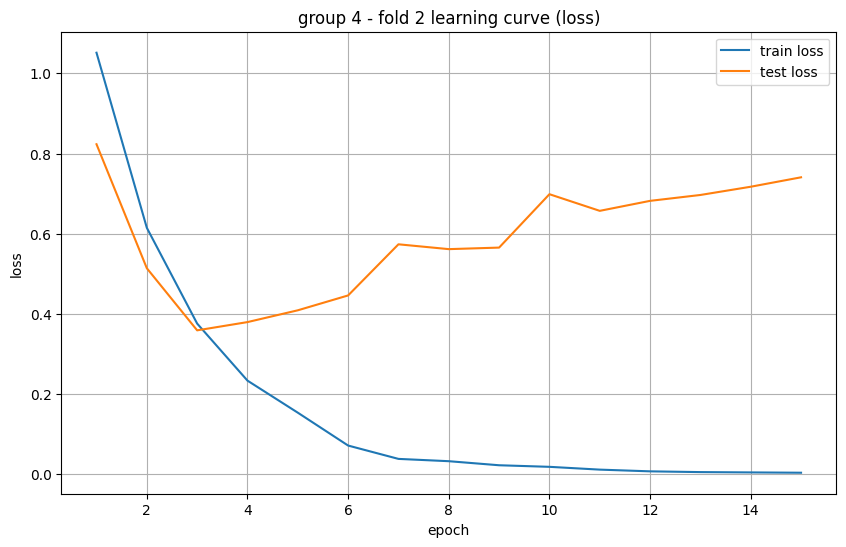

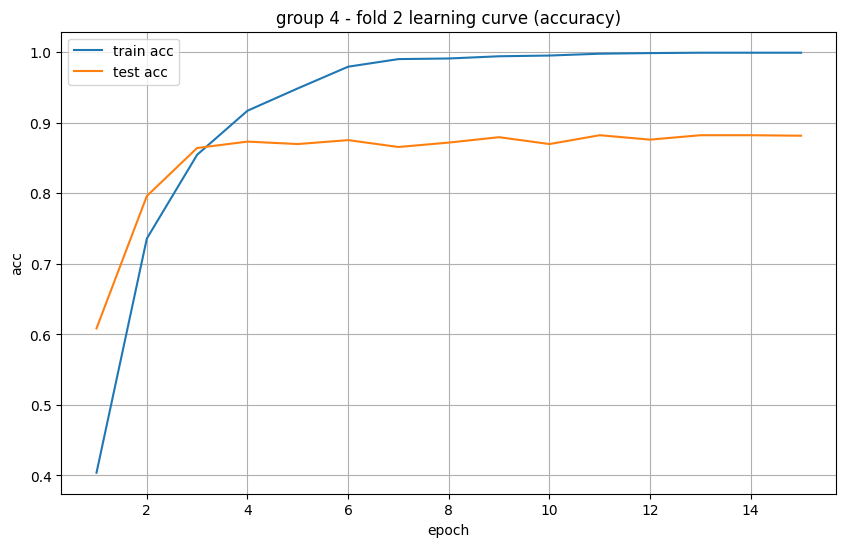

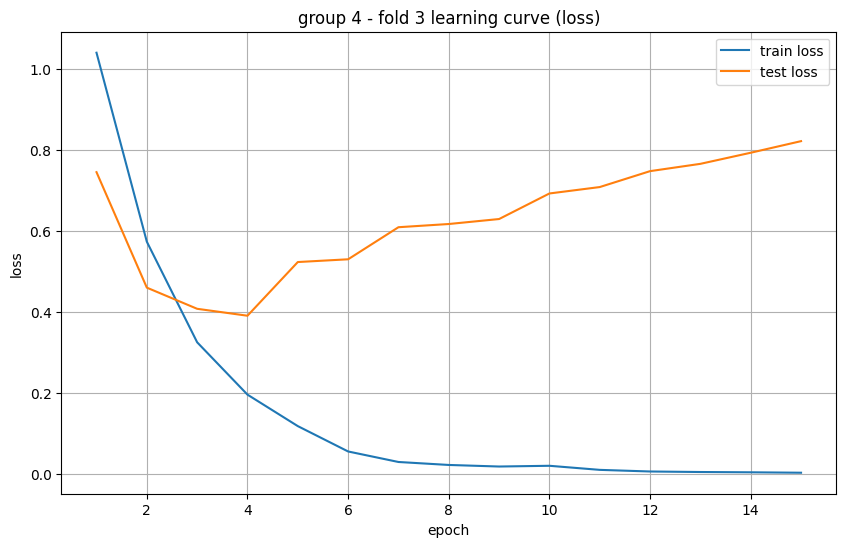

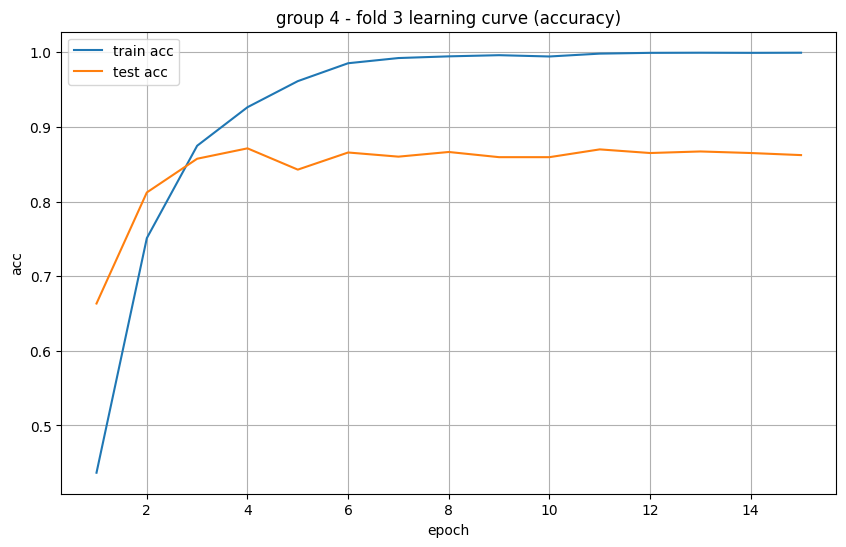

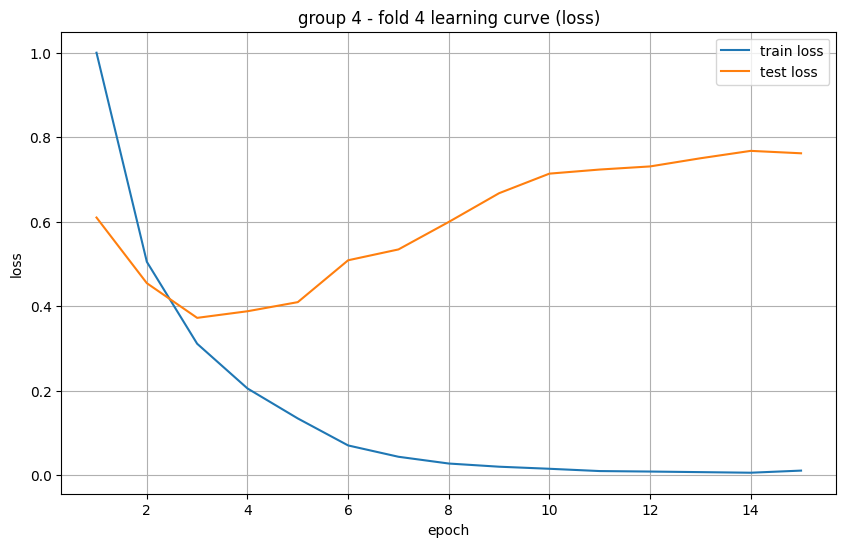

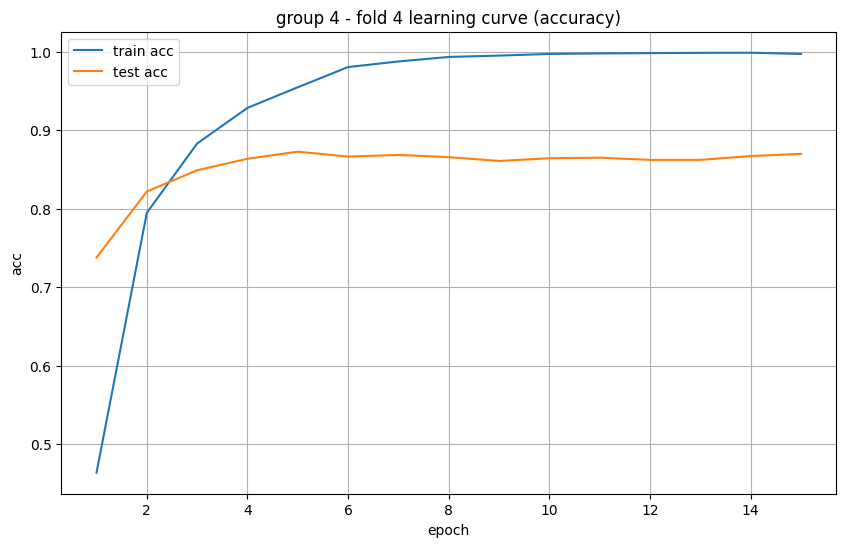

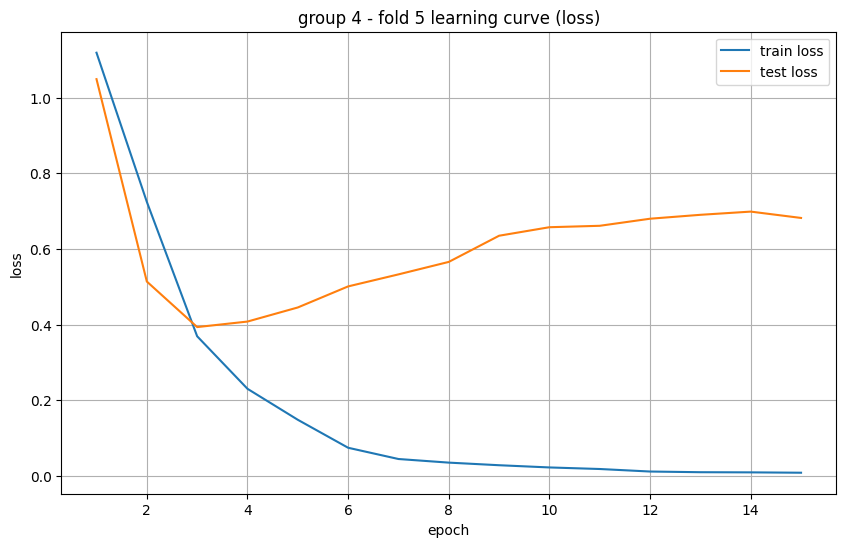

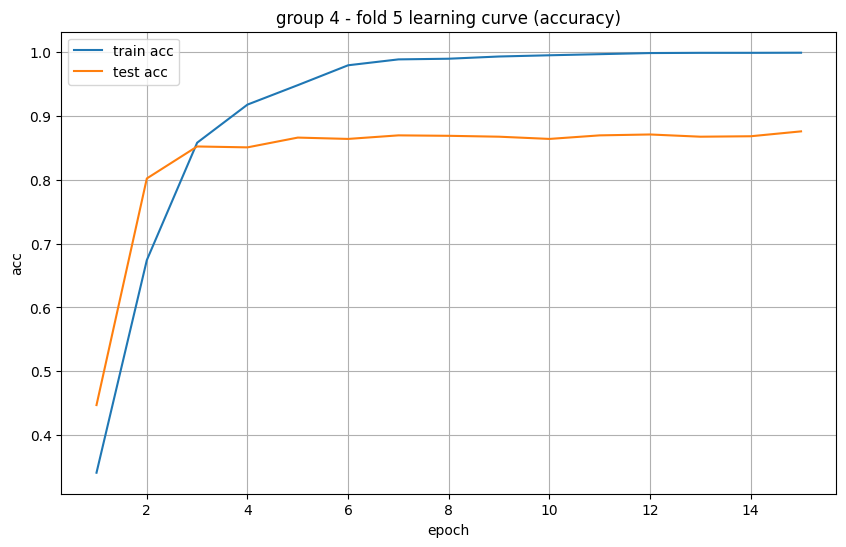

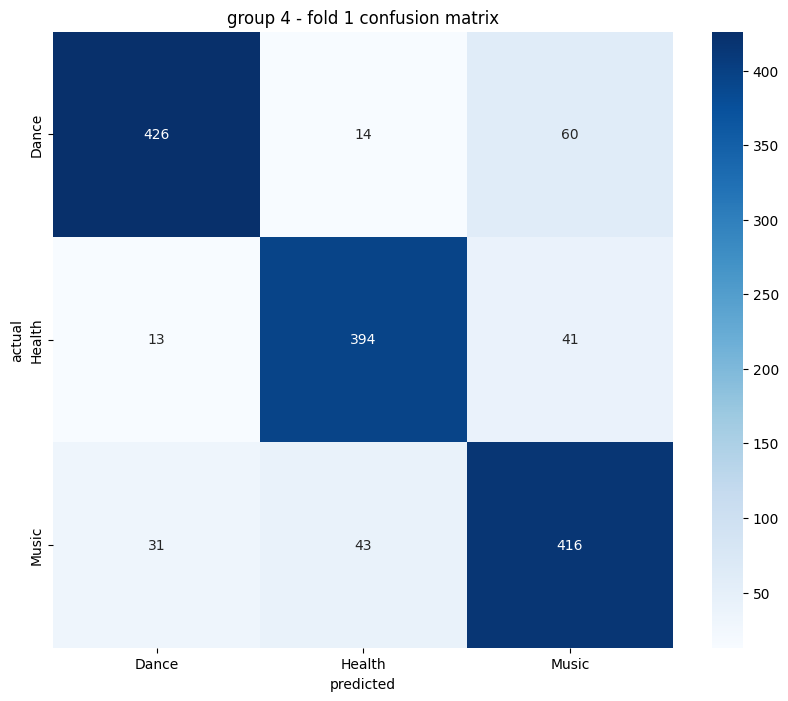

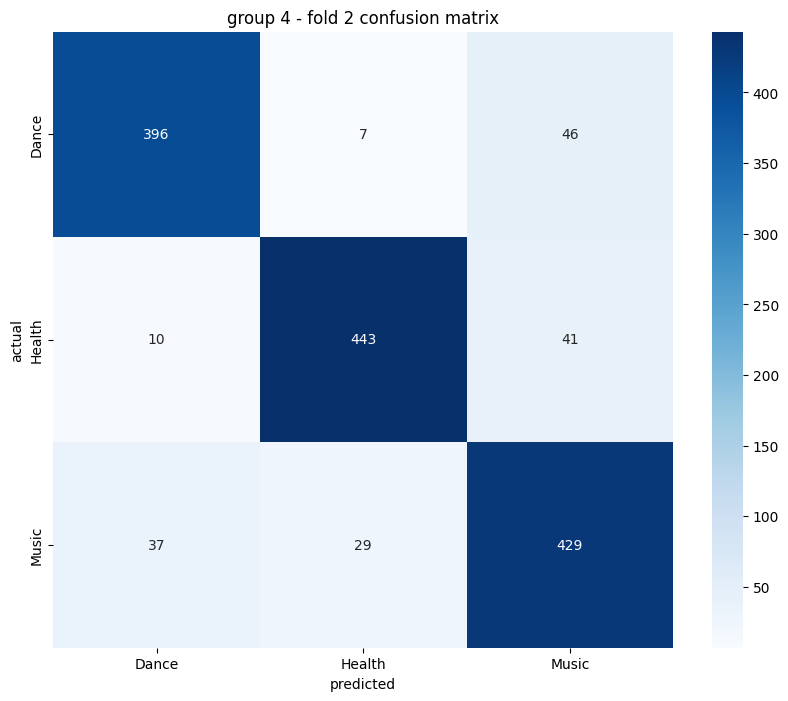

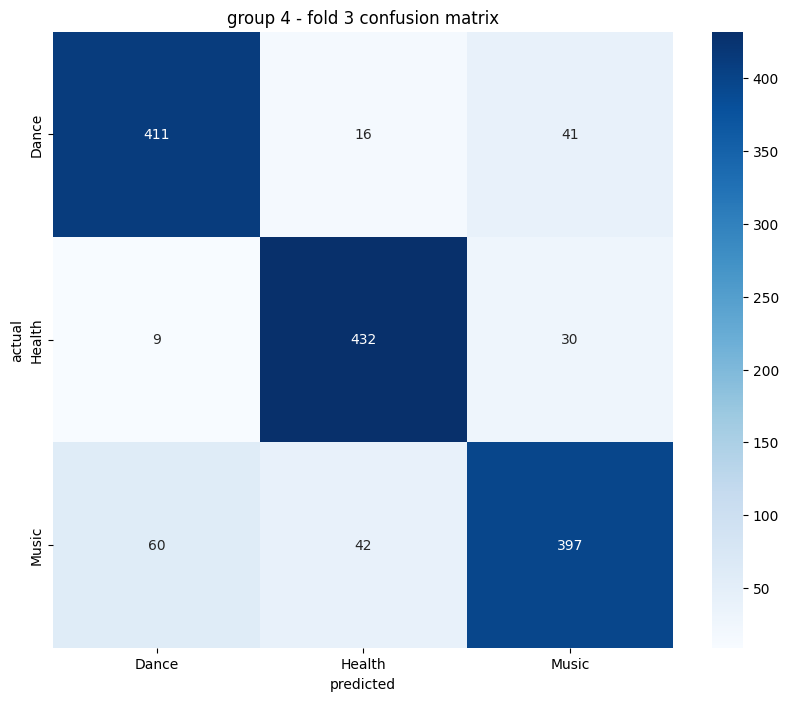

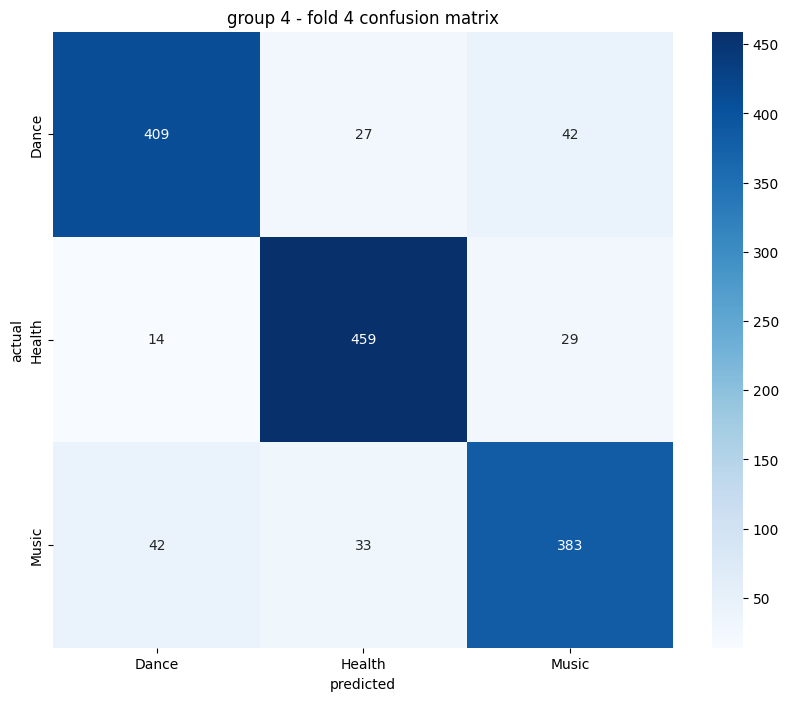

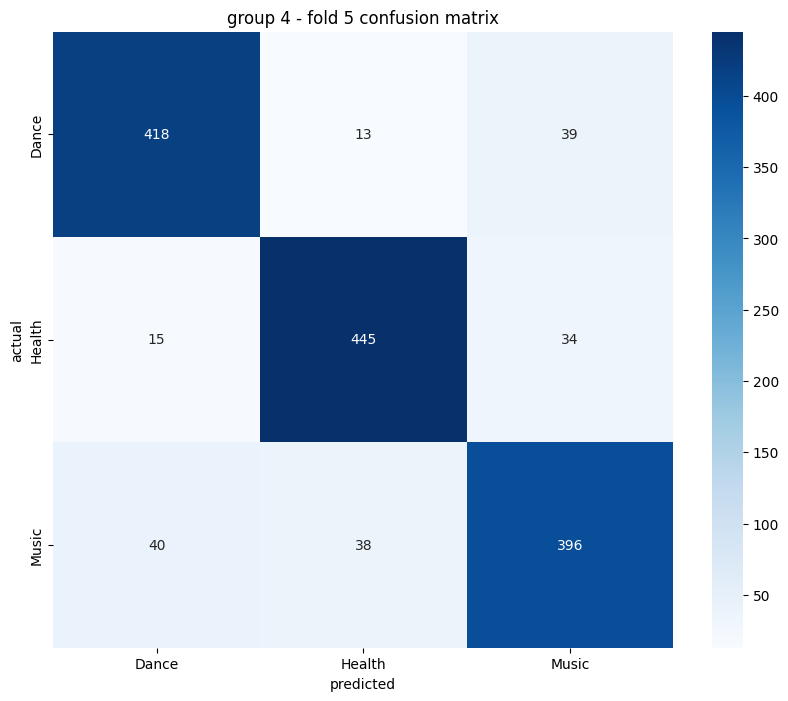


group 5 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 1.0637, train acc: 0.4348
                               test loss: 0.9254, test acc: 0.5487
    epoch 5/15: train loss: 0.2553, train acc: 0.9167
                               test loss: 0.6187, test acc: 0.7955
    epoch 10/15: train loss: 0.0628, train acc: 0.9843
                               test loss: 0.9526, test acc: 0.7851
    epoch 15/15: train loss: 0.0166, train acc: 0.9969
                               test loss: 1.2136, test acc: 0.7907

  fold 2/5 처리 중...
    epoch 1/15: train loss: 1.0568, train acc: 0.4350
                               test loss: 0.8827, test acc: 0.5695
    epoch 5/15: train loss: 0.2510, train acc: 0.9165
                               test loss: 0.5739, test acc: 0.7907
    epoch 10/15: train loss: 0.0455, train acc: 0.9875
                               test loss: 1.1298, test acc: 0.7643
    epoch 15/15: train loss: 0.0108, train acc: 0.9979
                               test lo

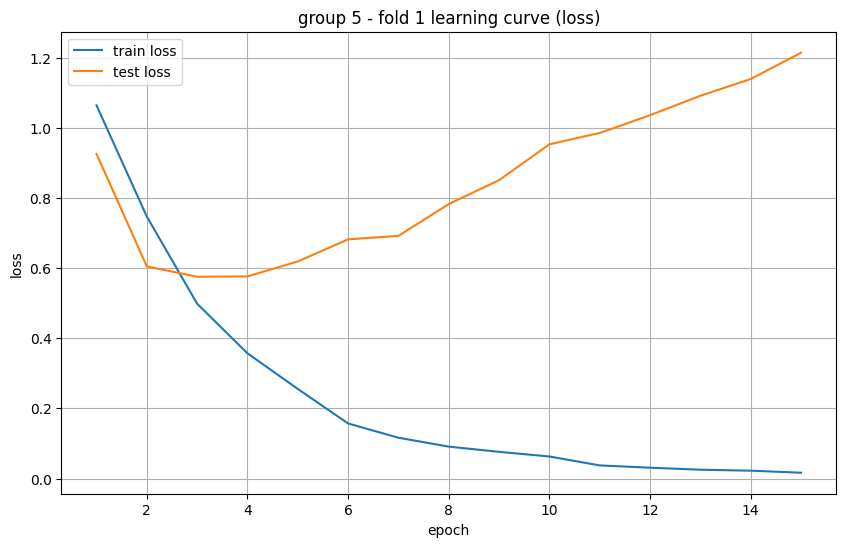

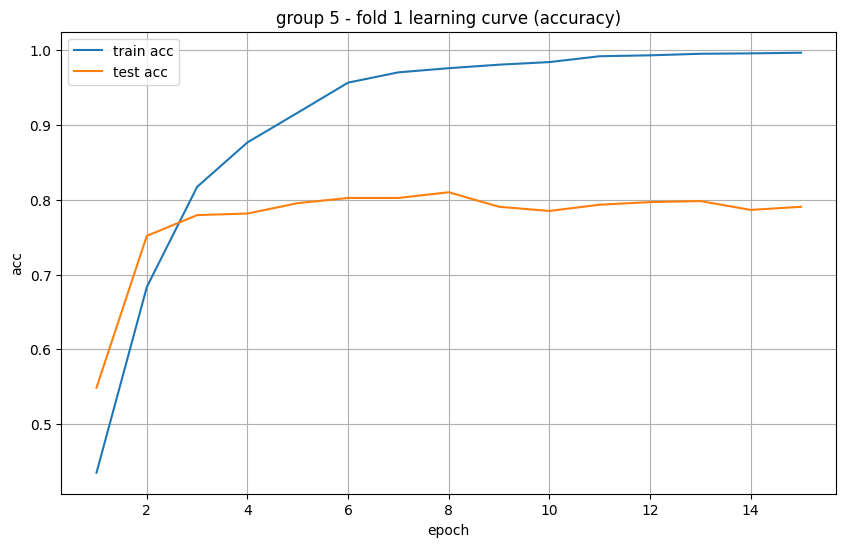

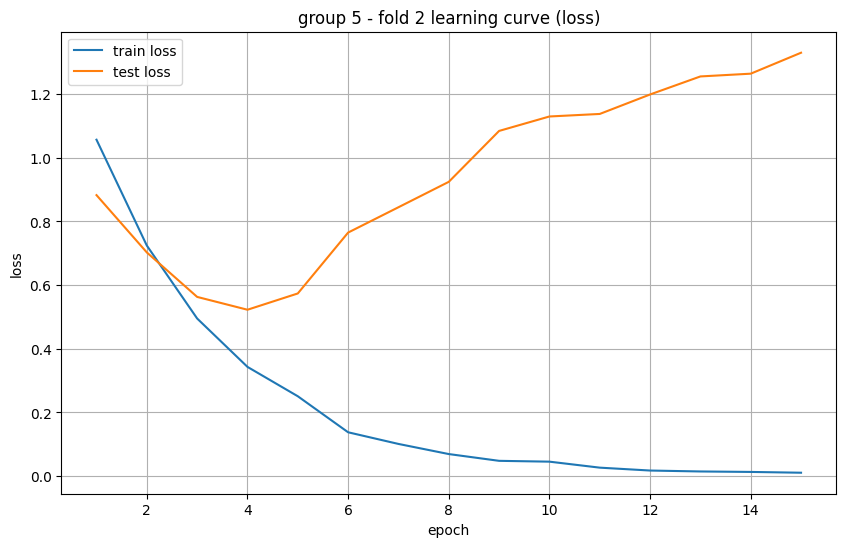

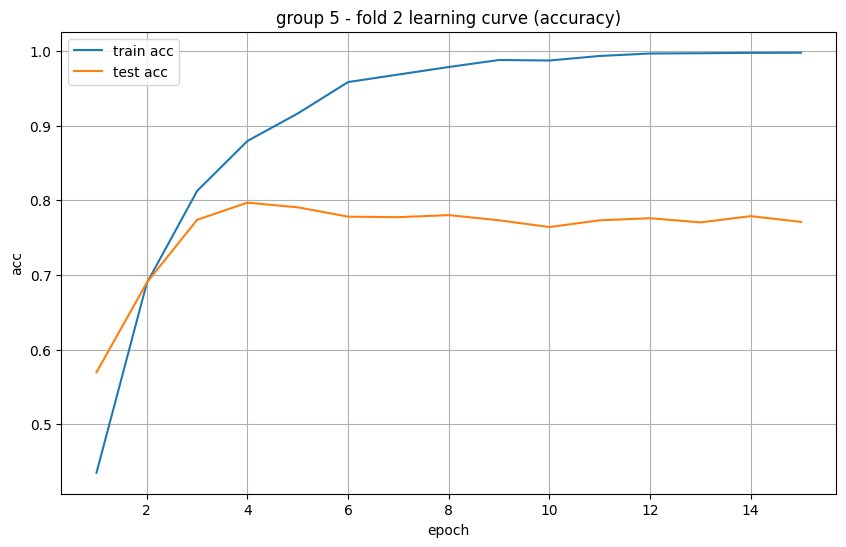

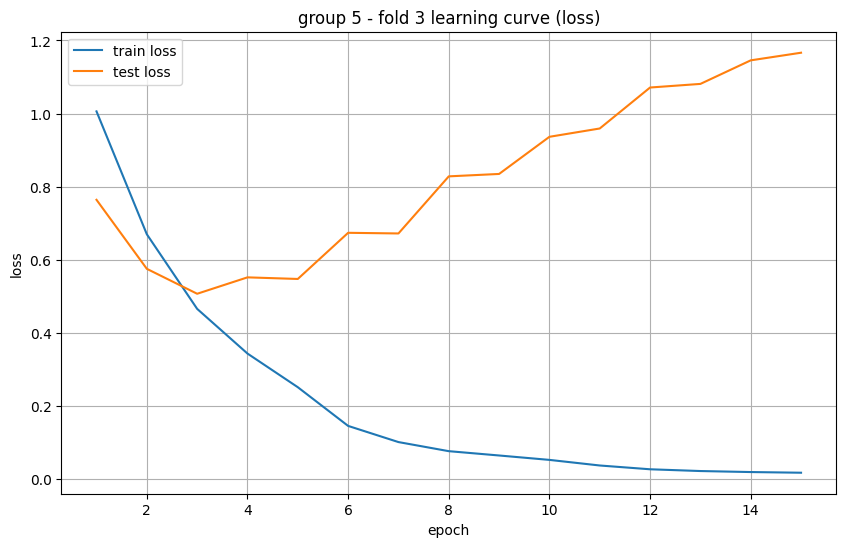

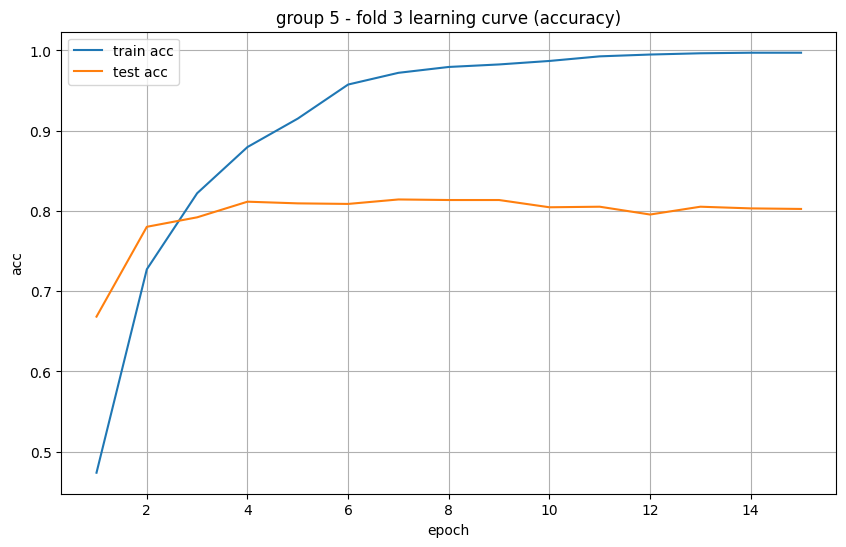

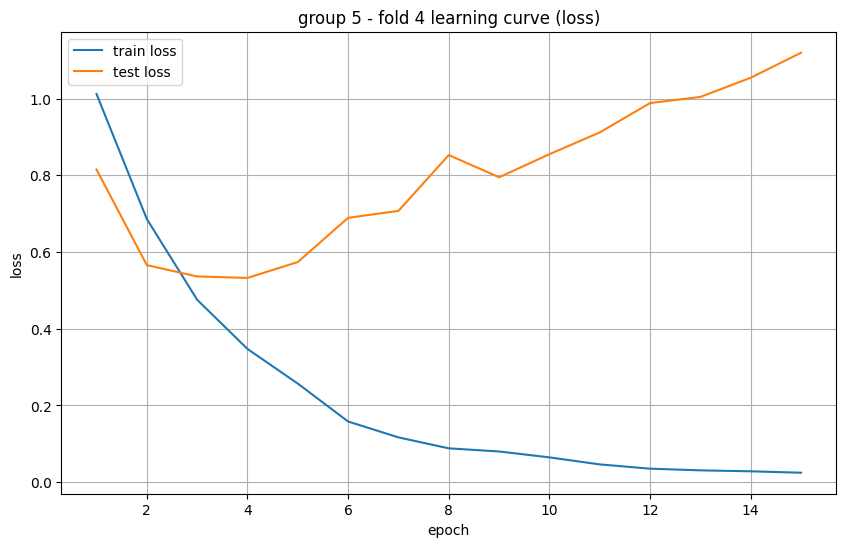

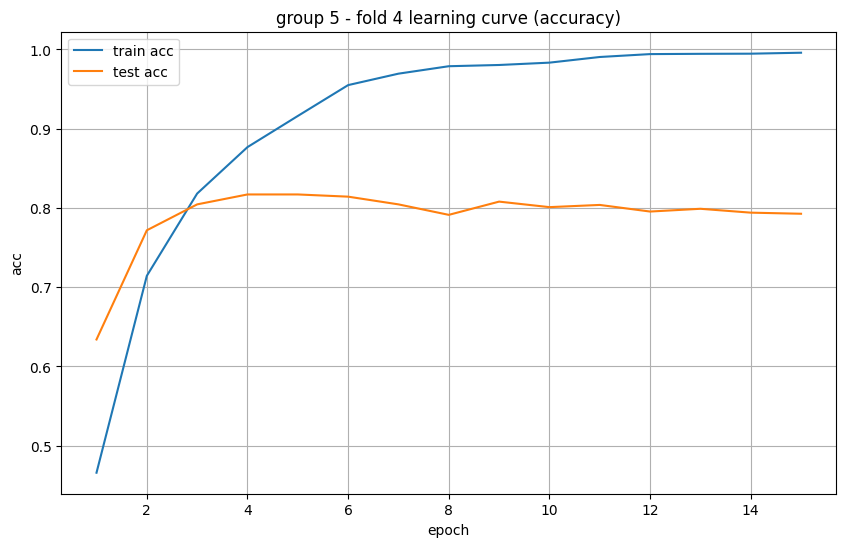

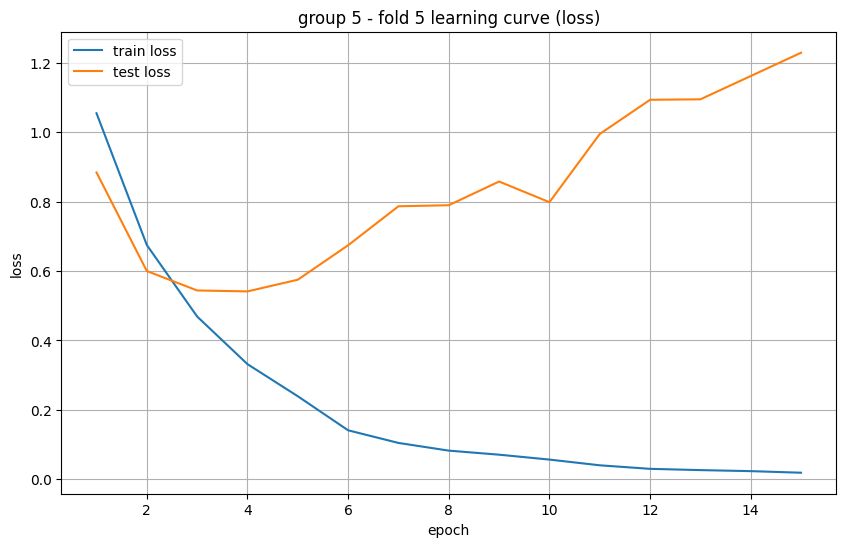

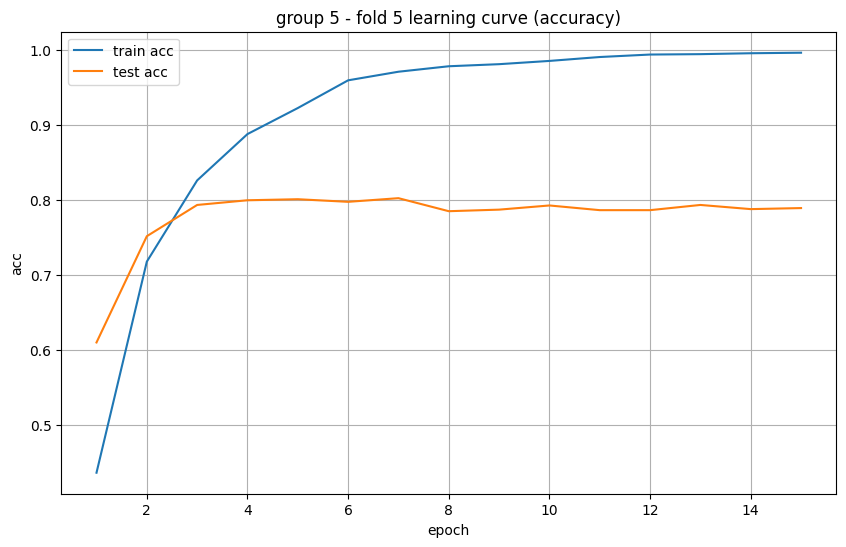

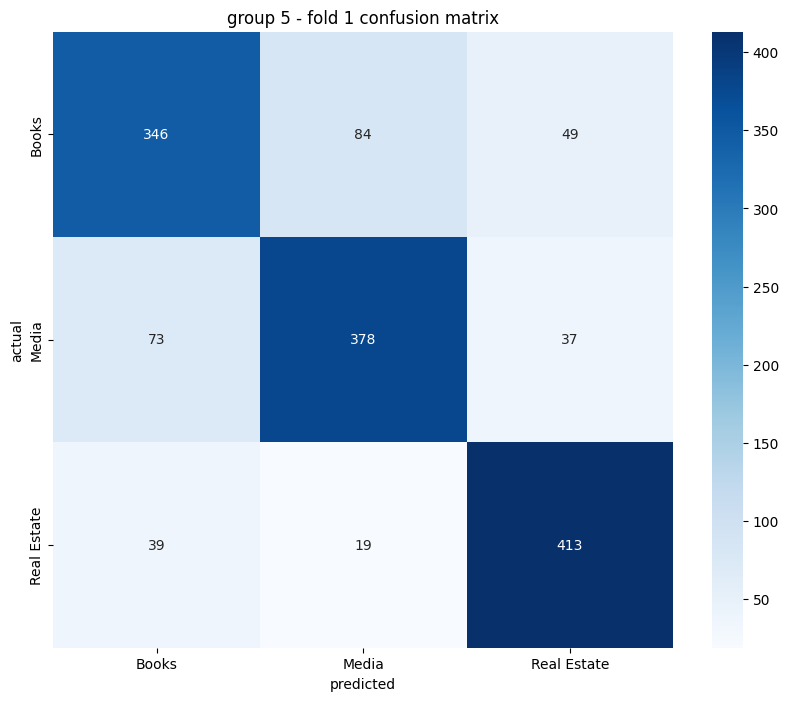

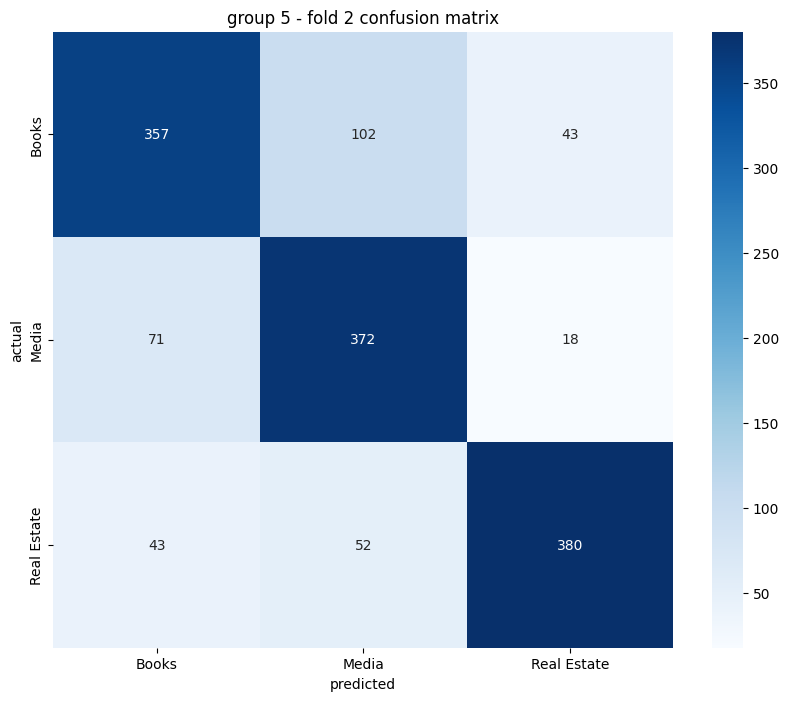

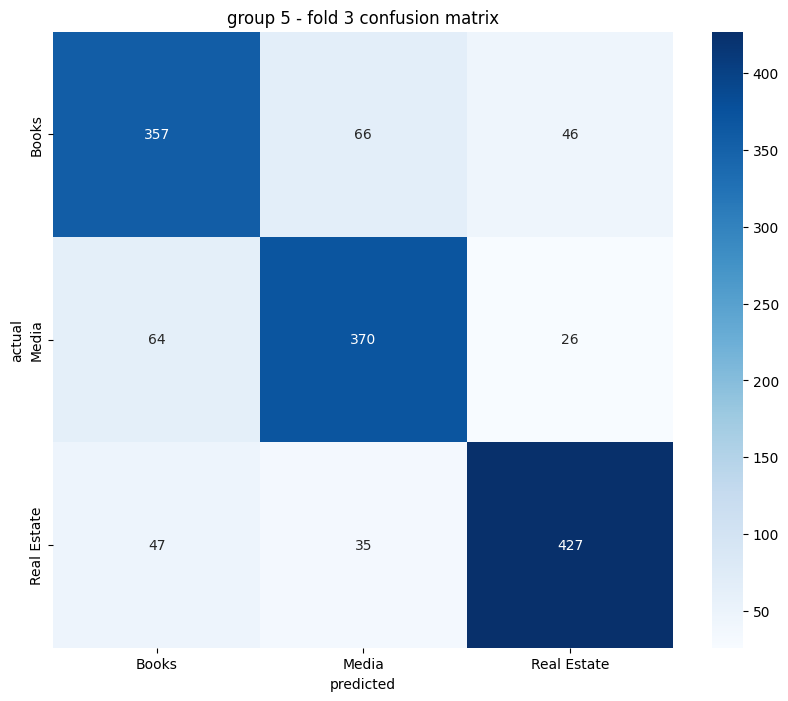

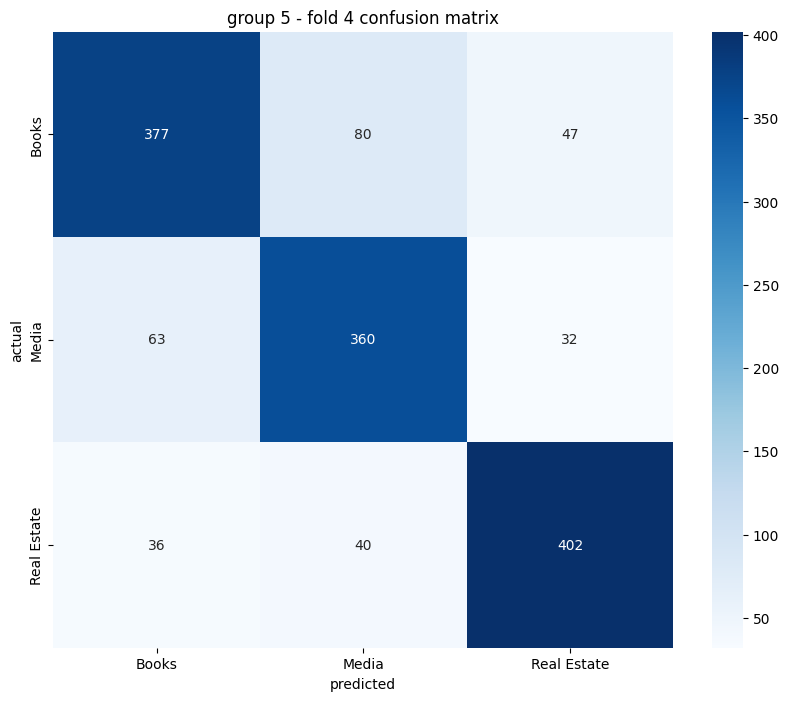

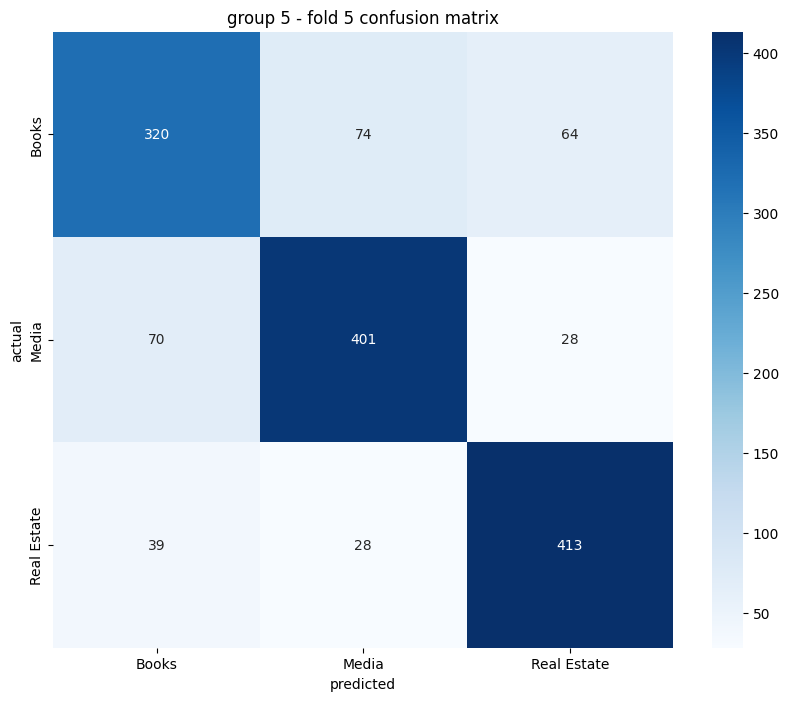


group 6 처리 중...

  fold 1/5 처리 중...
    epoch 1/15: train loss: 0.8539, train acc: 0.6033
                               test loss: 0.6007, test acc: 0.7826
    epoch 5/15: train loss: 0.1812, train acc: 0.9443
                               test loss: 0.4420, test acc: 0.8576
    epoch 10/15: train loss: 0.0203, train acc: 0.9958
                               test loss: 0.7163, test acc: 0.8597
    epoch 15/15: train loss: 0.0059, train acc: 0.9991
                               test loss: 0.8497, test acc: 0.8625

  fold 2/5 처리 중...
    epoch 1/15: train loss: 0.8728, train acc: 0.5792
                               test loss: 0.5846, test acc: 0.8000
    epoch 5/15: train loss: 0.1617, train acc: 0.9512
                               test loss: 0.3478, test acc: 0.8924
    epoch 10/15: train loss: 0.0406, train acc: 0.9898
                               test loss: 0.5299, test acc: 0.8764
    epoch 15/15: train loss: 0.0121, train acc: 0.9983
                               test lo

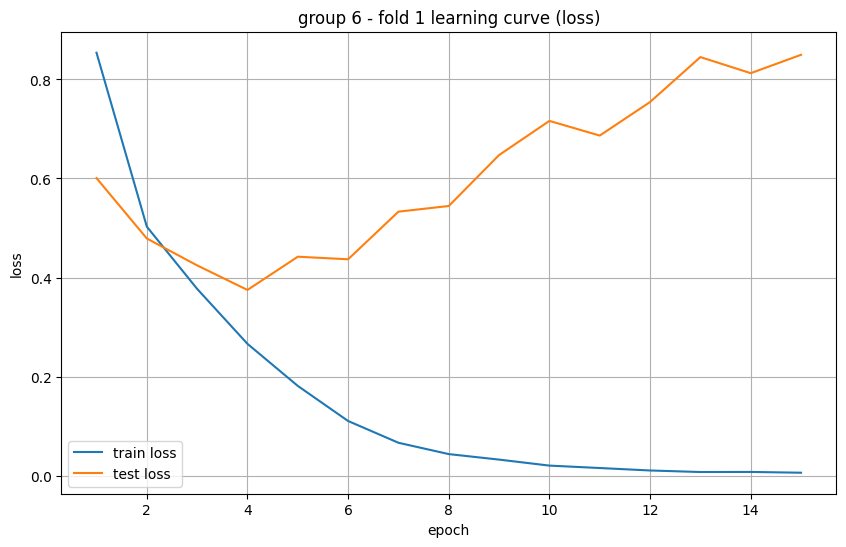

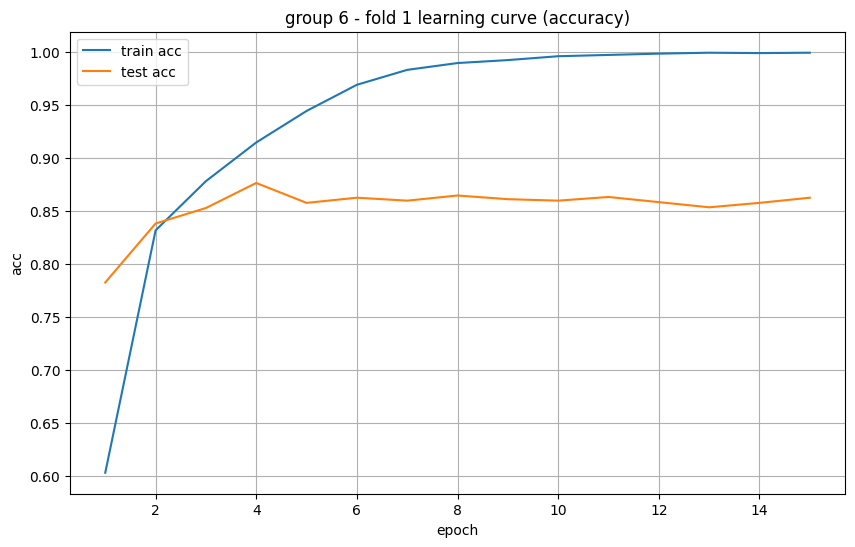

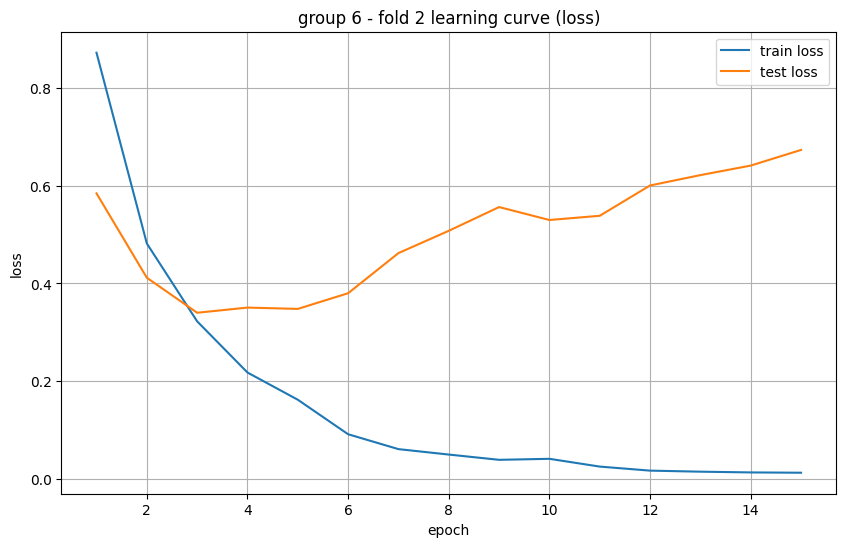

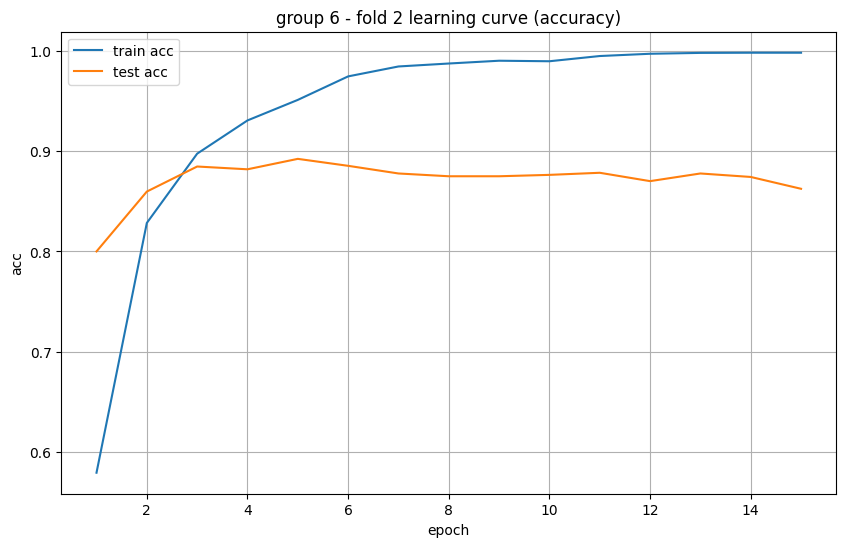

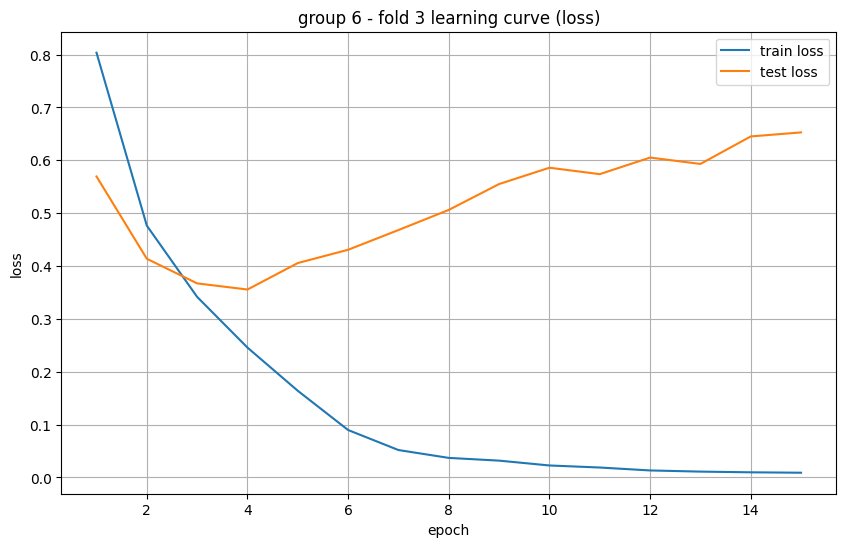

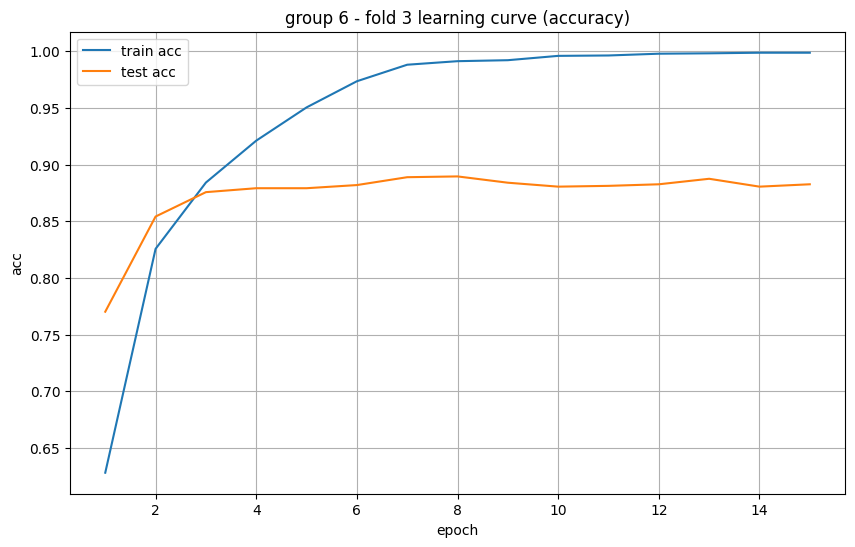

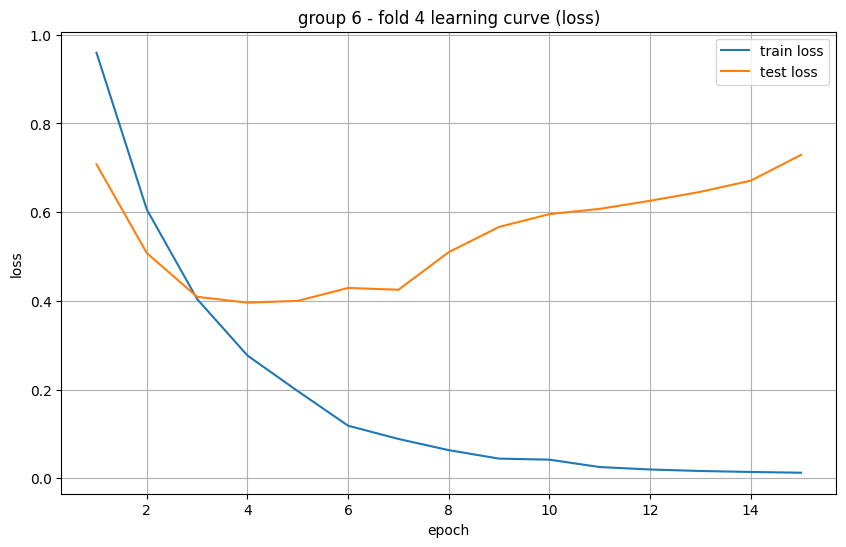

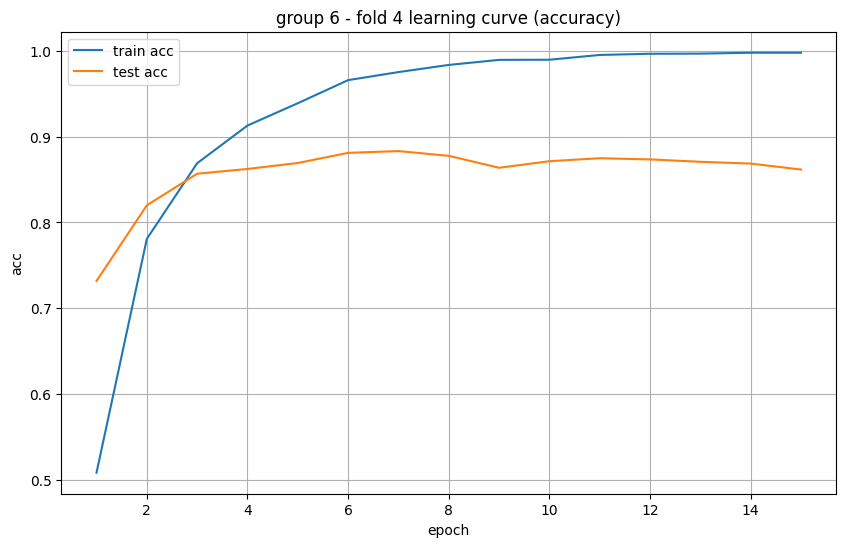

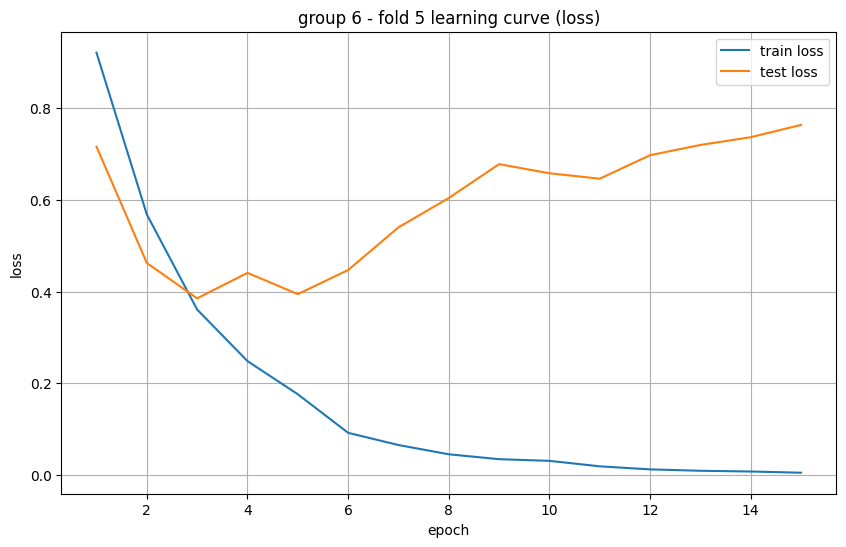

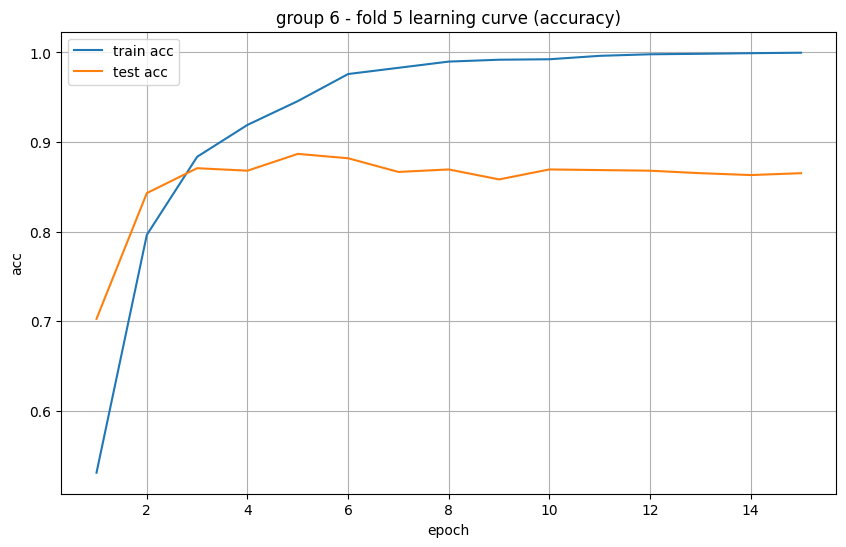

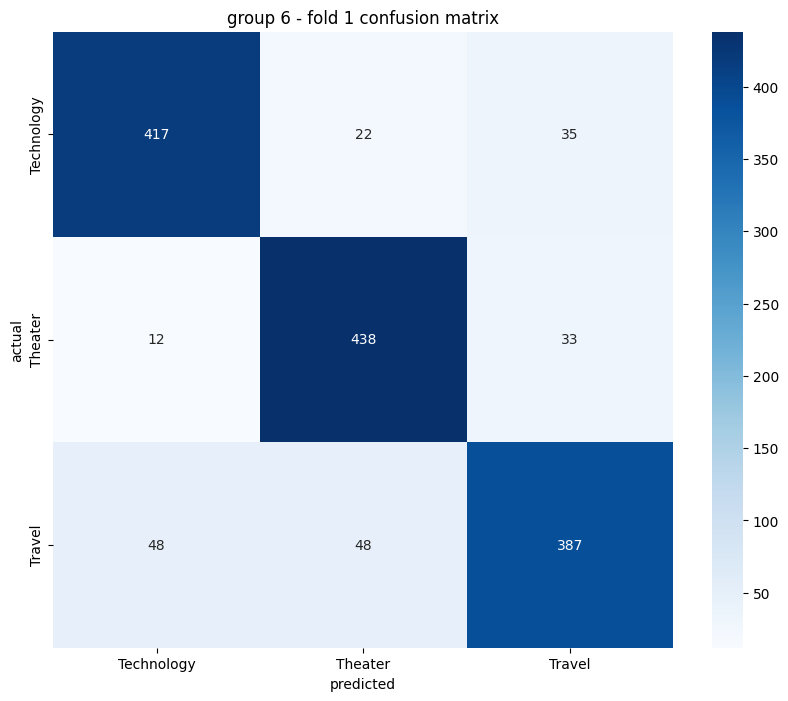

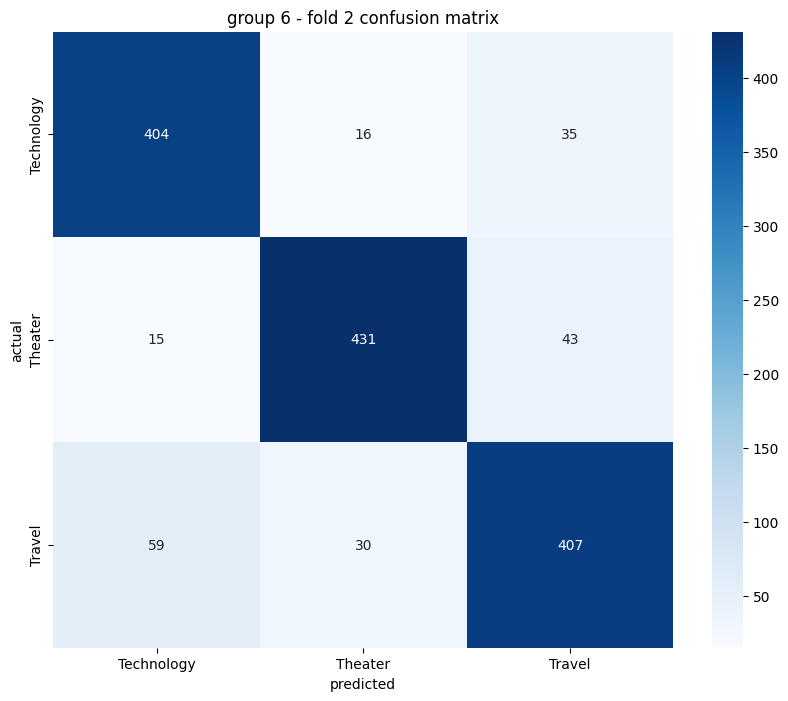

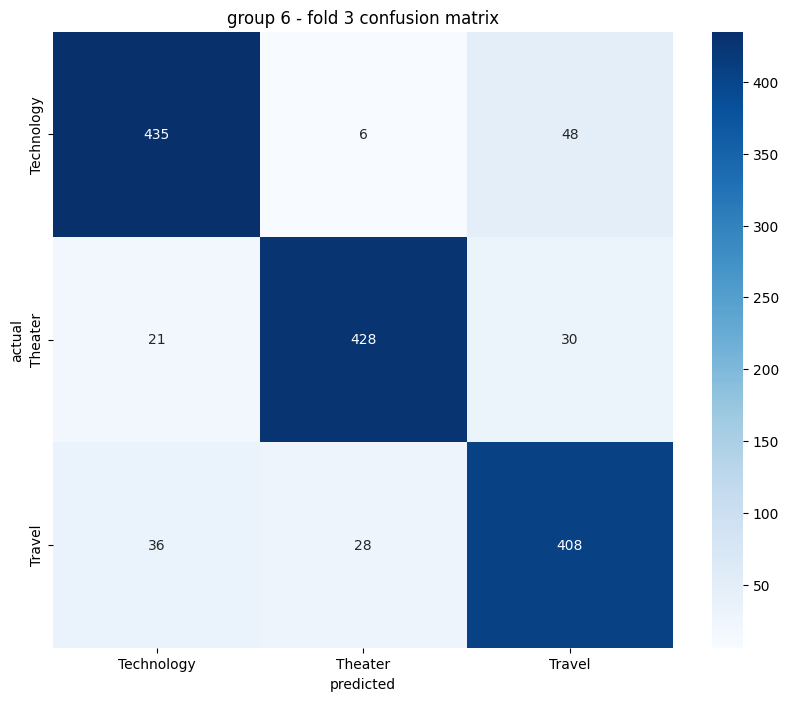

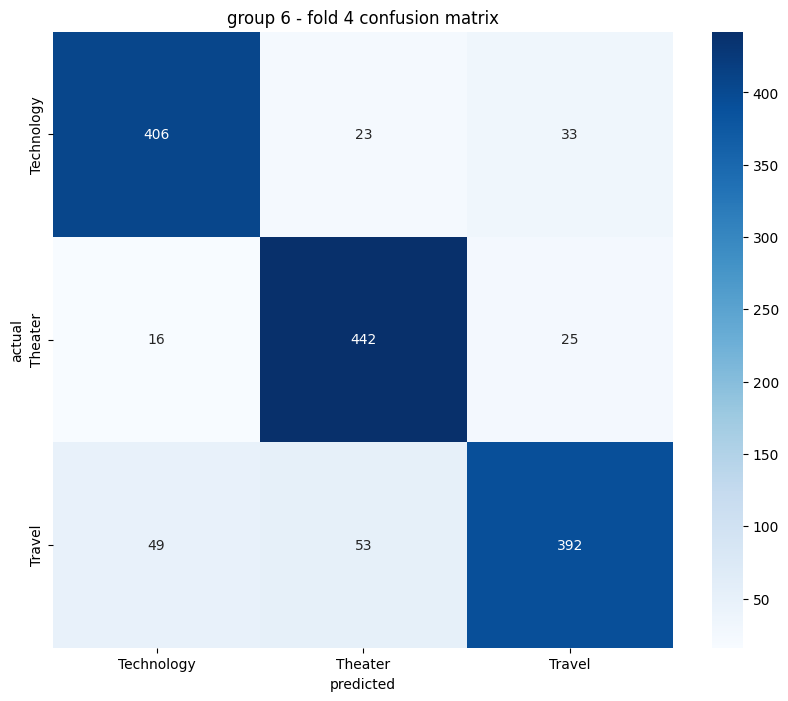

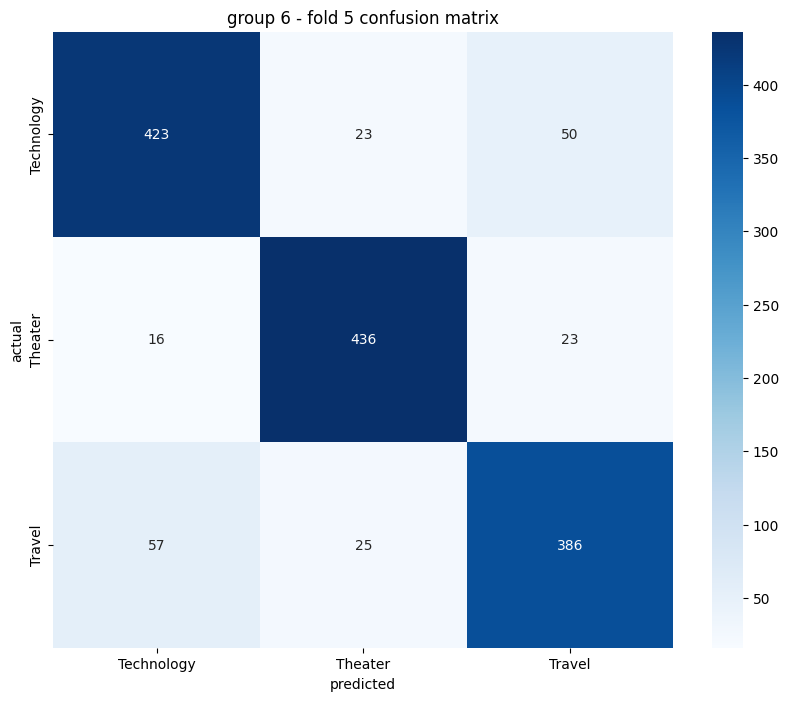


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.8561
  폴드 1: 테스트 정확도 = 0.8752
  폴드 2: 테스트 정확도 = 0.8668
  폴드 3: 테스트 정확도 = 0.8529
  폴드 4: 테스트 정확도 = 0.8563
  폴드 5: 테스트 정확도 = 0.8293

그룹 2 - 평균 테스트 정확도: 0.7909
  폴드 1: 테스트 정확도 = 0.7988
  폴드 2: 테스트 정확도 = 0.7876
  폴드 3: 테스트 정확도 = 0.7557
  폴드 4: 테스트 정확도 = 0.8076
  폴드 5: 테스트 정확도 = 0.8049

그룹 3 - 평균 테스트 정확도: 0.8021
  폴드 1: 테스트 정확도 = 0.8043
  폴드 2: 테스트 정확도 = 0.8043
  폴드 3: 테스트 정확도 = 0.7964
  폴드 4: 테스트 정확도 = 0.8178
  폴드 5: 테스트 정확도 = 0.7877

그룹 4 - 평균 테스트 정확도: 0.8698
  폴드 1: 테스트 정확도 = 0.8595
  폴드 2: 테스트 정확도 = 0.8818
  폴드 3: 테스트 정확도 = 0.8623
  폴드 4: 테스트 정확도 = 0.8700
  폴드 5: 테스트 정확도 = 0.8755

그룹 5 - 평균 테스트 정확도: 0.7892
  폴드 1: 테스트 정확도 = 0.7907
  폴드 2: 테스트 정확도 = 0.7712
  폴드 3: 테스트 정확도 = 0.8025
  폴드 4: 테스트 정확도 = 0.7926
  폴드 5: 테스트 정확도 = 0.7891

그룹 6 - 평균 테스트 정확도: 0.8669
  폴드 1: 테스트 정확도 = 0.8625
  폴드 2: 테스트 정확도 = 0.8625
  폴드 3: 테스트 정확도 = 0.8826
  폴드 4: 테스트 정확도 = 0.8617
  폴드 5: 테스트 정확도 = 0.8652


In [27]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    with open(val_loader_save_path, 'wb') as f:
        pickle.dump(best_valid_loader, f) 
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")
    print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")